In [1]:
import numpy as np
import pandas as pd
import skexplain
import seaborn as sns
import plotting_config
import itertools
import scipy
import xarray as xr
import scipy.stats as sps
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from sklearn.ensemble import RandomForestRegressor

In [2]:
from time_series_deconfounder import *
from loguru import logger

2024-09-15 20:50:31.528822: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-15 20:50:31.585100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-15 20:50:32.413352: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:Using GPU with memory growth
2024-09-15 20:50:33.605903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46816 MB memory:  

Number of devices: 1


In [3]:
dataset = load_data("../data/sample_32w_add.h5")

index_to_remove = dataset['covariates'].shape[2] - 5
dataset['covariates'] = np.delete(dataset['covariates'], index_to_remove, axis=2)

index_to_remove = dataset['covariates'].shape[2] - 5
dataset['covariates'] = np.delete(dataset['covariates'], index_to_remove, axis=2)

for key in dataset.keys():
    print(key)
    print(dataset[key].shape)
    print(dataset[key].dtype)

covariates
(981651, 161, 23)
float32
outcomes
(981651, 161, 1)
float32
sequence_length
(981651,)
int64
treatments
(981651, 161, 1)
float32


In [4]:
column_2019 = 12  # index of year 2019 indicator
column_2023 = 14  # index of year 2023 indicator
dataset19 = obtain_dataset(dataset, column_2019)
dataset19 = dataset_sampling(dataset19, num_select=32000)

dataset23 = obtain_dataset(dataset, column_2023)
dataset23 = dataset_sampling(dataset23, num_select=32000)

In [5]:
# 计算全局的quantile
bins = 20
default_quantiles = np.unique(
   np.quantile(
       dataset['treatments'].reshape(-1), np.linspace(0, 1, bins + 1), interpolation="lower"
   )
)

the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


In [6]:
def _get_centres(x):
    return (x[1:] + x[:-1]) / 2

def _check_two_ints(values):
    if isinstance(values, (int, np.integer)):
        values = (values, values)
    elif len(values) == 1:
        values = (values[0], values[0])
    elif len(values) != 2:
        raise ValueError(
            "'{}' values were given. Expected at most 2.".format(len(values))
        )

    if not all(isinstance(n_bin, (int, np.integer)) for n_bin in values):
        raise ValueError(
            "All values must be an integer. Got types '{}' instead.".format(
                {type(n_bin) for n_bin in values}
            )
        )
    return values

In [7]:
exp_name = "base_model_optimal_v2"

In [8]:
del dataset; gc.collect()

0

## Gender & Age

### 分组一阶效应

2024-09-12 23:45:17.976 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.4599216  3.8934736  4.1615095  4.362593   4.5293097
  4.6761084  4.8103347  4.9385166  5.0629673  5.186283   5.3118725
  5.4416094  5.5796742  5.735624   5.909291   6.1114674  6.356732
  6.6670737  7.143829  13.569432 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 0it [00:00, ?it/s]2024-09-12 23:45:20.105590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
Predicting rnn_propensity_weighted: 175it [00:05, 31.86it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 175it [00:05, 30.58it/s]
2024-09-12 23:45:33.207 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.4599216  3.8934736  4.1615095  4.362593   4.5293097
  4.6761084  4.8103347  4.9385166  5.0629673  5.186283   5.3118725
  5.4416094  5.5796742  5.735624   5.909291   6.1114674  6.356732
  6.6670737  7.143829  13.569432 ].


[ 1.7299608  3.6766977  4.0274916  4.2620516  4.4459515  4.602709
  4.7432213  4.874426   5.000742   5.124625   5.249078   5.376741
  5.510642   5.657649   5.8224573  6.010379   6.2340994  6.511903
  6.9054513 10.35663  ]


2024-09-12 23:45:57.683 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.3481576  3.7790241  4.0464463  4.248424   4.4156704
  4.5624056  4.696003   4.8239965  4.94762    5.0703406  5.1937046
  5.3220224  5.459395   5.611393   5.7851386  5.987779   6.239929
  6.559346   7.0536156 13.550374 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 326it [00:09, 33.79it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 326it [00:09, 33.46it/s]
2024-09-12 23:46:22.523 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.3481576  3.7790241  4.0464463  4.248424   4.4156704
  4.5624056  4.696003   4.8239965  4.94762    5.0703406  5.1937046
  5.3220224  5.459395   5.611393   5.7851386  5.987779   6.239929
  6.559346   7.0536156 13.550374 ].


[ 1.6740788  3.563591   3.9127352  4.147435   4.3320475  4.489038
  4.6292043  4.7599998  4.885808   5.0089803  5.132023   5.2578635
  5.390709   5.5353937  5.698266   5.886459   6.1138544  6.3996377
  6.806481  10.301994 ]


2024-09-12 23:46:35.784 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.9960456  4.3568044  4.5810027  4.75567    4.9038715
  5.035037   5.1556163  5.269526   5.381033   5.4889584  5.5952454
  5.704228   5.8196383  5.9456434  6.089281   6.260543   6.4716654
  6.7491813  7.1594296 12.425694 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 177it [00:05, 33.06it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 177it [00:05, 33.88it/s]
2024-09-12 23:46:50.256 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.9960456  4.3568044  4.5810027  4.75567    4.9038715
  5.035037   5.1556163  5.269526   5.381033   5.4889584  5.5952454
  5.704228   5.8196383  5.9456434  6.089281   6.260543   6.4716654
  6.7491813  7.1594296 12.425694 ].


[1.9980228 4.176425  4.4689035 4.6683364 4.829771  4.9694543 5.0953264
 5.212571  5.325279  5.4349957 5.542102  5.6497364 5.7619333 5.882641
 6.0174623 6.174912  6.366104  6.610423  6.9543056 9.7925625]


2024-09-12 23:47:14.400 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.9147668  4.2778025  4.5043616  4.678674   4.825974
  4.956068   5.075464   5.1887555  5.298539   5.405699   5.5130014
  5.6250043  5.744733   5.874977   6.022343   6.19985    6.424051
  6.7248793  7.177606  12.1644745].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 324it [00:09, 34.53it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 324it [00:09, 33.17it/s]
2024-09-12 23:47:38.950 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.9147668  4.2778025  4.5043616  4.678674   4.825974
  4.956068   5.075464   5.1887555  5.298539   5.405699   5.5130014
  5.6250043  5.744733   5.874977   6.022343   6.19985    6.424051
  6.7248793  7.177606  12.1644745].


[1.9573834 4.096285  4.391082  4.591518  4.752324  4.891021  5.015766
 5.1321096 5.2436476 5.352119  5.45935   5.569003  5.684869  5.809855
 5.94866   6.1110964 6.3119507 6.574465  6.9512424 9.671041 ]


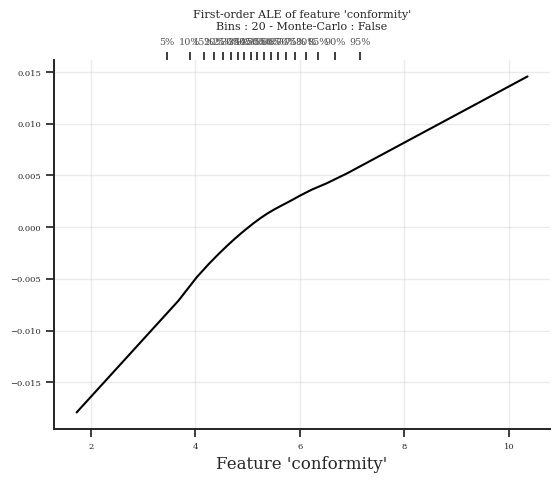

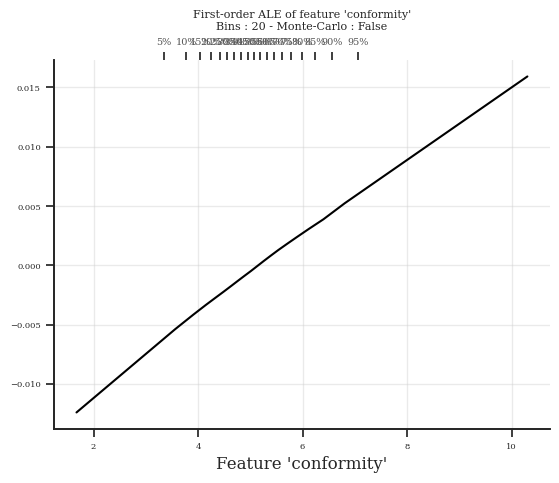

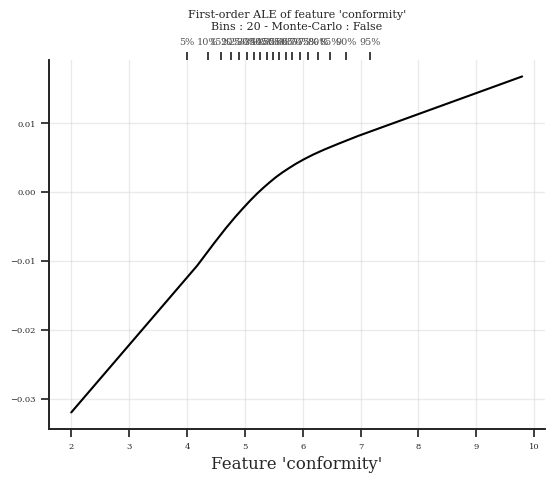

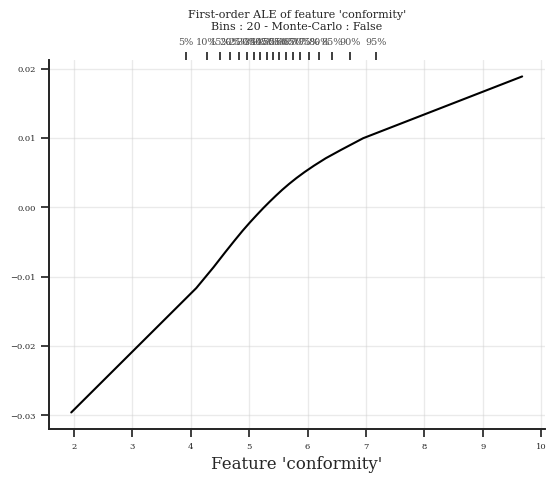

In [8]:
column_gender = 0
ALE = []
for dataset in [dataset19, dataset23]:
    ale_list = []
    for gender in [0,1]:
        dataset_subgender = obtain_dataset(dataset, column_gender, selection=gender)
        _, ale, _ = compute_ale(dataset_subgender, 'rmsn_' + str(exp_name), b_use_predicted_confounders=False, 
                                features=['conformity'], default_quantiles=default_quantiles)
        ale_list.append(ale)
    ALE.append(ale_list)

In [19]:
np.array(ALE).max()

0.01888050636890152

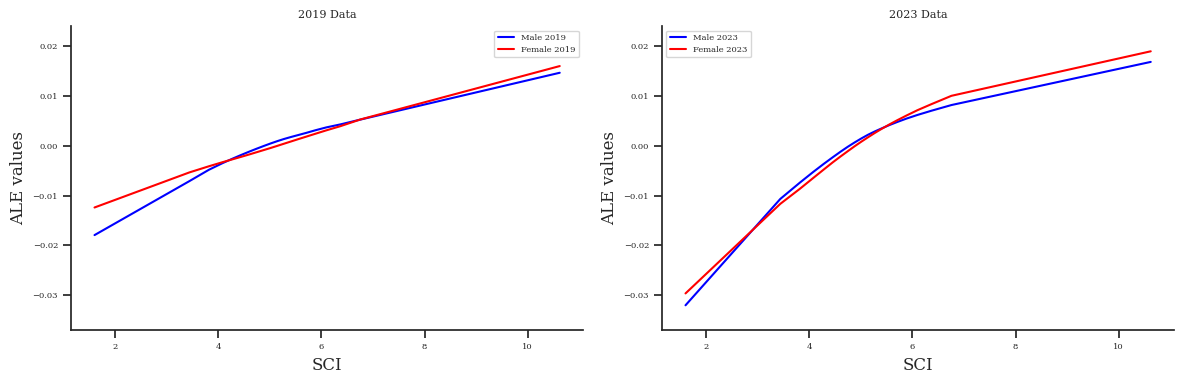

In [21]:
# 绘制不同gender的曲线图
# 创建1×2的图窗
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
x = _get_centres(default_quantiles)
y_min = np.array(ALE).min()
y_max = np.array(ALE).max()

# 2019年数据
axs[0].plot(x, ALE[0][0], label='Male 2019', color='blue')
axs[0].plot(x, ALE[0][1], label='Female 2019', color='red')
axs[0].set_title('2019 Data')
axs[0].set_xlabel('SCI')
axs[0].set_ylabel('ALE values')
axs[0].set_ylim(y_min-0.005, y_max+0.005)
axs[0].legend()

# 2023年数据
axs[1].plot(x, ALE[1][0], label='Male 2023', color='blue')
axs[1].plot(x, ALE[1][1], label='Female 2023', color='red')
axs[1].set_title('2023 Data')
axs[1].set_xlabel('SCI')
axs[1].set_ylabel('ALE values')
axs[1].set_ylim(y_min-0.005, y_max+0.005)
axs[1].legend()

# 显示图像
plt.tight_layout()
plt.show()

In [11]:
ALE_array = np.array(ALE)
ALED = np.mean(np.abs(ALE_array), axis=2)

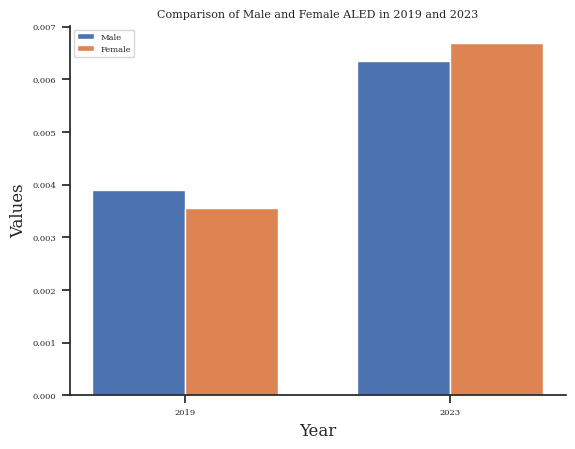

In [13]:
years = ['2019', '2023']

# Plotting the bar chart
fig, ax = plt.subplots()

# Bar width and positions
bar_width = 0.35
index = np.arange(len(years))

# Creating bars for each gender
bar1 = ax.bar(index, ALED[:, 0], bar_width, label='Male')
bar2 = ax.bar(index + bar_width, ALED[:, 1], bar_width, label='Female')

# Adding labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Values')
ax.set_title('Comparison of Male and Female ALED in 2019 and 2023')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(years)
ax.legend()

# Display the plot
plt.show()

2024-09-15 20:52:21.442 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.3940883  3.8281927  4.096373   4.298013   4.464634
  4.610389   4.743746   4.8707848  4.994068   5.1163416  5.240982
  5.3693447  5.508366   5.6604633  5.8342257  6.037296   6.286015
  6.6040053  7.091792  14.007114 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 0it [00:00, ?it/s]2024-09-15 20:52:25.146792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
Predicting rnn_propensity_weighted: 484it [00:14, 34.14it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 484it [00:14, 34.43it/s]
2024-09-15 20:52:57.166 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.3940883  3.8281927  4.096373   4.298013   4.464634
  4.610389   4.743746   4.8707848  4.994068   5.1163416  5.240982
  5.3693447  5.508366   5.6604633  5.8342257  6.037296   6.286015
  6.6040053  7.091792  14.007114 ].


[ 1.6970441  3.6111405  3.962283   4.197193   4.381324   4.537512
  4.6770678  4.8072653  4.9324265  5.055205   5.178662   5.3051634
  5.438855   5.5844145  5.7473445  5.9357605  6.1616554  6.44501
  6.8478985 10.549454 ]


2024-09-15 20:52:57.974 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.3471467  3.776199   4.036884   4.2347407  4.391843
  4.5379324  4.6625376  4.7856655  4.898544   5.0039067  5.1124506
  5.2272325  5.3485017  5.463532   5.6008472  5.7755885  5.9880576
  6.312949   6.943763  12.839512 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 8it [00:01,  7.37it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 0it [00:00, ?it/s]WARNING:5 out of the last 493 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fdb84132a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Predicting rnn_propensity_weighted: 8it [00:00, 10.13it/s]
2024-09-15 20:53:02.010

[1.6735734 3.561673  3.9065413 4.1358123 4.3132915 4.4648876 4.600235
 4.7241015 4.842105  4.9512253 5.058179  5.169842  5.287867  5.406017
 5.5321894 5.688218  5.881823  6.150503  6.628356  9.891638 ]


2024-09-15 20:53:02.839 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.1027226  3.5737245  3.8539743  4.0722504  4.2451525
  4.403572   4.5399513  4.662931   4.7844195  4.9081383  5.0301914
  5.1526     5.2816467  5.4060845  5.5640817  5.7382584  5.9705915
  6.2766433  6.8036084 12.801747 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 0it [00:00, ?it/s]WARNING:5 out of the last 17 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fdb643755e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Predicting rnn_propensity_weighted: 9it [00:00, 10.73it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 9it [00:00, 11.22it/s]
2024-09-15 20:53:07.069 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.1027226  3.5737245  3.8539743  4.0722504  4.2451525
  4.403572   4.5399513  4.662931   4.7844195  4.9081383  5.0301914
  5.1526     5.2816467  5.4060845  5.5640817  5.7382584  5.9705915
  6.2766433  6.8036084 12.801747 ].


[1.5513613 3.3382235 3.7138495 3.9631124 4.1587014 4.3243623 4.4717617
 4.6014414 4.7236753 4.846279  4.969165  5.0913954 5.217123  5.3438654
 5.485083  5.65117   5.854425  6.123617  6.540126  9.802678 ]


2024-09-15 20:53:47.502 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.9515452  4.314275   4.539472   4.7112365  4.856214
  4.985671   5.1049113  5.217355   5.326673   5.4345717  5.5417643
  5.6521373  5.7700605  5.8977213  6.0416226  6.2172065  6.435683
  6.724661   7.173743  12.7279005].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 486it [00:13, 35.05it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 486it [00:13, 35.14it/s]
2024-09-15 20:54:22.871 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.9515452  4.314275   4.539472   4.7112365  4.856214
  4.985671   5.1049113  5.217355   5.326673   5.4345717  5.5417643
  5.6521373  5.7700605  5.8977213  6.0416226  6.2172065  6.435683
  6.724661   7.173743  12.7279005].


[1.9757726 4.13291   4.426873  4.6253543 4.7837253 4.9209423 5.045291
 5.161133  5.2720137 5.3806224 5.488168  5.5969505 5.7110987 5.833891
 5.969672  6.1294146 6.3264446 6.5801716 6.9492016 9.950822 ]


2024-09-15 20:54:23.638 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.15142211  3.9385724   4.240508    4.4366474   4.5995502   4.74831
  4.8685374   4.9834986   5.0929666   5.19636     5.295456    5.401966
  5.5030355   5.6044917   5.7060504   5.811374    5.9288244   6.0739512
  6.274568    6.654318   11.235603  ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 7it [00:00,  8.38it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 7it [00:00,  9.32it/s]
2024-09-15 20:54:27.653 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.15142211  3.9385724   4.240508    4.4366474   4.5995502   4.74831
  4.8685374   4.9834986   5.0929666   5.19636     5.295456    5.401966
  5.5030355   5.6044917   5.7060504   5.811374    5.9288244   6.0739512
  6.274568    6.654318   11.235603  ].


[2.0449972 4.0895405 4.3385777 4.518099  4.67393   4.808424  4.9260178
 5.038233  5.1446633 5.245908  5.348711  5.452501  5.5537634 5.655271
 5.7587123 5.870099  6.0013876 6.1742597 6.464443  8.944961 ]


2024-09-15 20:54:28.425 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.08491659  3.9041746   4.2371817   4.479549    4.646698    4.798258
  4.9356046   5.0556836   5.1638417   5.263739    5.3686733   5.473432
  5.5805154   5.6886935   5.802671    5.9304967   6.0813513   6.268965
  6.542247    6.9233646  10.622692  ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 9it [00:01,  7.82it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 9it [00:00,  9.93it/s]
2024-09-15 20:54:32.923 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.08491659  3.9041746   4.2371817   4.479549    4.646698    4.798258
  4.9356046   5.0556836   5.1638417   5.263739    5.3686733   5.473432
  5.5805154   5.6886935   5.802671    5.9304967   6.0813513   6.268965
  6.542247    6.9233646  10.622692  ].


[1.9945456 4.070678  4.358365  4.5631237 4.722478  4.866931  4.995644
 5.1097627 5.2137904 5.316206  5.421053  5.5269737 5.6346045 5.7456822
 5.866584  6.005924  6.175158  6.405606  6.7328057 8.773028 ]


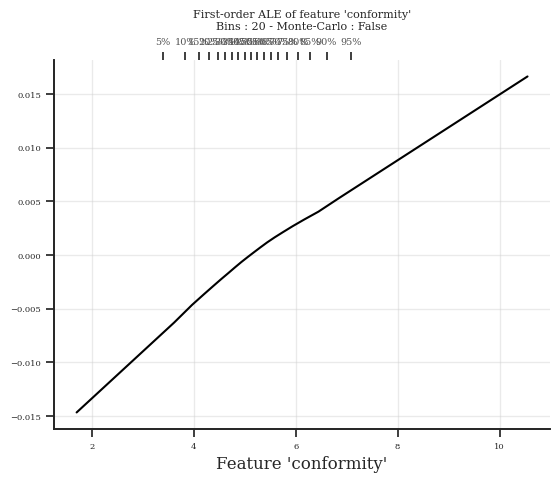

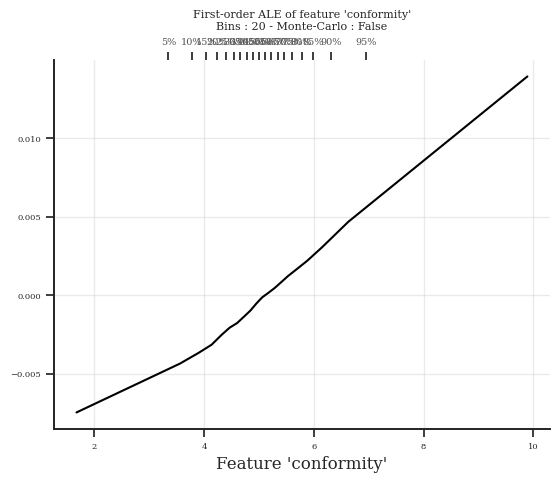

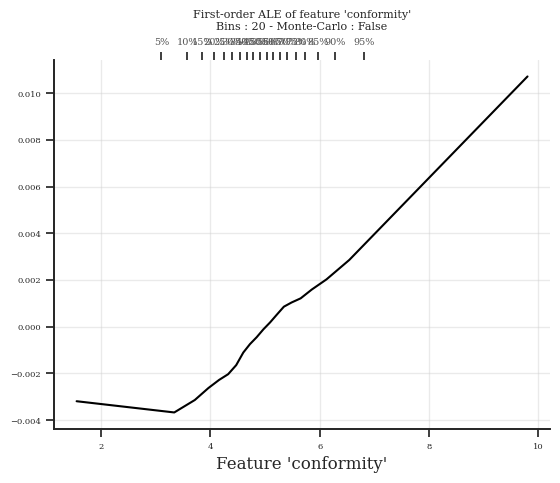

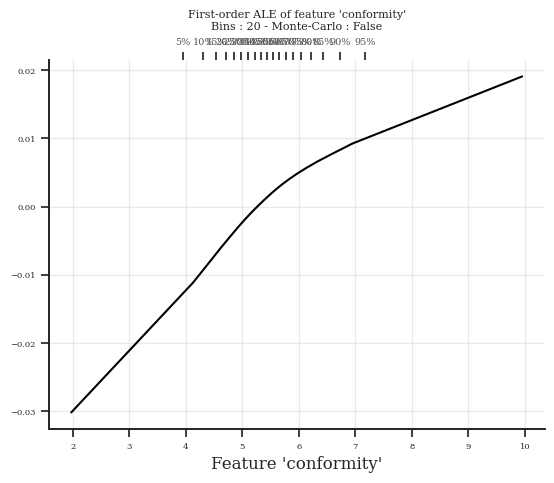

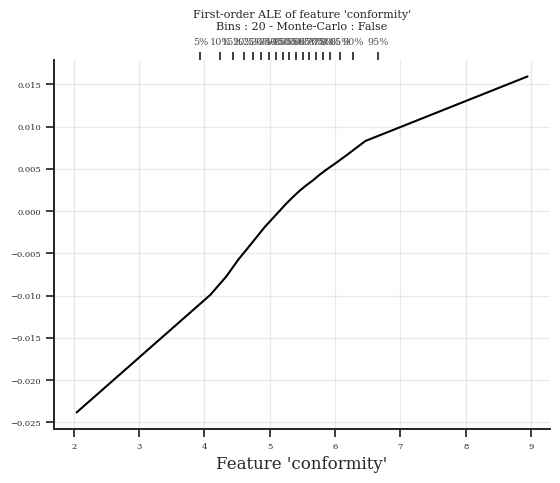

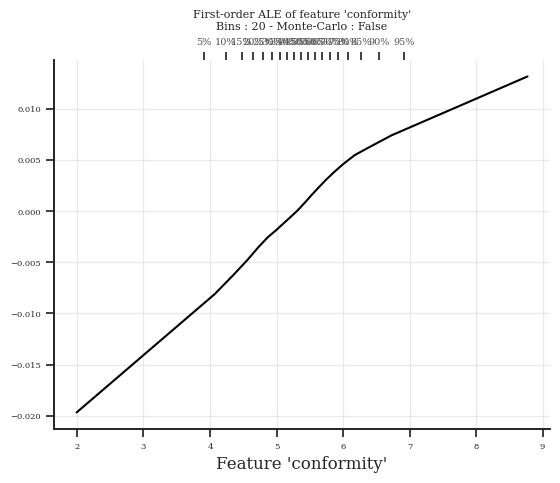

In [9]:
column_age = 1
ALE = []
for dataset in [dataset19, dataset23]:
    ale_list = []
    for age in range(3):
        dataset_subage = obtain_dataset(dataset, column_age, selection=age)
        _, ale, _ = compute_ale(dataset_subage, 'rmsn_' + str(exp_name), b_use_predicted_confounders=False, 
                                features=['conformity'], default_quantiles=default_quantiles)
        ale_list.append(ale)
    ALE.append(ale_list)

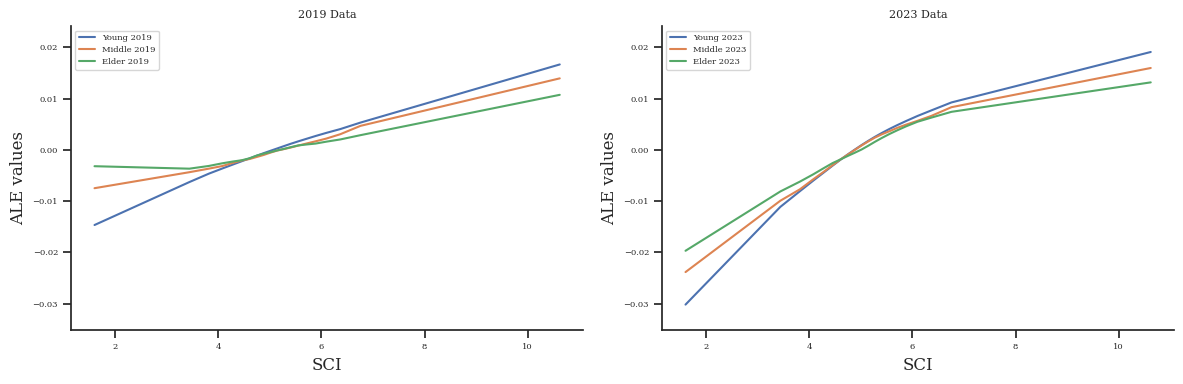

In [14]:
# 绘制不同gender的曲线图
# 创建1×2的图窗
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
x = _get_centres(default_quantiles)
y_min = np.array(ALE).min()
y_max = np.array(ALE).max()

# 2019年数据
axs[0].plot(x, ALE[0][0], label='Young 2019')
axs[0].plot(x, ALE[0][1], label='Middle 2019')
axs[0].plot(x, ALE[0][2], label='Elder 2019')
axs[0].set_title('2019 Data')
axs[0].set_xlabel('SCI')
axs[0].set_ylabel('ALE values')
axs[0].set_ylim(y_min-0.005, y_max+0.005)
axs[0].legend()

# 2023年数据
axs[1].plot(x, ALE[1][0], label='Young 2023')
axs[1].plot(x, ALE[1][1], label='Middle 2023')
axs[1].plot(x, ALE[1][2], label='Elder 2023')
axs[1].set_title('2023 Data')
axs[1].set_xlabel('SCI')
axs[1].set_ylabel('ALE values')
axs[1].set_ylim(y_min-0.005, y_max+0.005)
axs[1].legend()

# 显示图像
plt.tight_layout()
plt.show()

In [15]:
ALE_array = np.array(ALE)
ALED = np.mean(np.abs(ALE_array), axis=2)

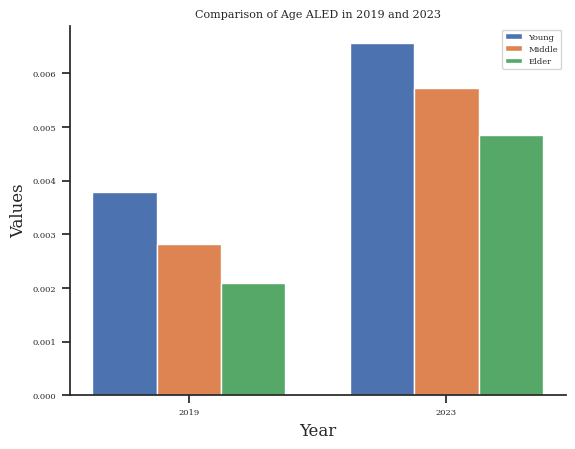

In [20]:
years = ['2019', '2023']

# Plotting the bar chart
fig, ax = plt.subplots()

# Bar width and positions
bar_width = 0.25
index = np.arange(len(years))

# Creating bars for each gender
bar1 = ax.bar(index, ALED[:, 0], bar_width, label='Young')
bar2 = ax.bar(index + bar_width, ALED[:, 1], bar_width, label='Middle')
bar3 = ax.bar(index + 2*bar_width, ALED[:, 2], bar_width, label='Elder')


# Adding labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Values')
ax.set_title('Comparison of Age ALED in 2019 and 2023')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(years)
ax.legend()

# Display the plot
plt.show()

## Income

In [42]:
dataset = load_data("../data/sample_32w.h5")

column_2019 = 12  # index of year 2019 indicator
column_2023 = 14  # index of year 2023 indicator
dataset19 = obtain_dataset(dataset, column_2019)
dataset19 = dataset_sampling(dataset19, num_select=32000)
dataset23 = obtain_dataset(dataset, column_2023)
dataset23 = dataset_sampling(dataset23, num_select=32000)

del dataset; gc.collect()

101412

2024-09-15 18:12:02.512 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.2067013  3.6026063  3.8456583  4.02734    4.1749787
  4.304065   4.419983   4.529441   4.63289    4.735452   4.839243
  4.9471827  5.063629   5.19115    5.3358727  5.5106506  5.7385855
  6.0562925  6.5664897 12.840348 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 100it [00:03, 27.54it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 100it [00:03, 29.95it/s]
2024-09-15 18:12:12.995 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.2067013  3.6026063  3.8456583  4.02734    4.1749787
  4.304065   4.419983   4.529441   4.63289    4.735452   4.839243
  4.9471827  5.063629   5.19115    5.3358727  5.5106506  5.7385855
  6.0562925  6.5664897 12.840348 ].


[1.6033506 3.4046538 3.7241323 3.936499  4.101159  4.239522  4.3620243
 4.474712  4.5811653 4.684171  4.787348  4.893213  5.005406  5.12739
 5.2635117 5.4232616 5.624618  5.897439  6.311391  9.703419 ]


2024-09-15 18:12:21.736 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.3056836  3.7457924  4.012477   4.215495   4.3834815
  4.528493   4.6584525  4.779996   4.896859   5.014388   5.1310434
  5.2522736  5.3835235  5.5312715  5.7013664  5.9029436  6.156988
  6.4856176  6.986377  13.99272  ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 100it [00:03, 26.74it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 100it [00:03, 27.55it/s]
2024-09-15 18:12:32.982 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.3056836  3.7457924  4.012477   4.215495   4.3834815
  4.528493   4.6584525  4.779996   4.896859   5.014388   5.1310434
  5.2522736  5.3835235  5.5312715  5.7013664  5.9029436  6.156988
  6.4856176  6.986377  13.99272  ].


[ 1.6528418  3.525738   3.8791347  4.113986   4.299488   4.455987
  4.5934725  4.719224   4.8384275  4.9556236  5.0727158  5.1916585
  5.3178988  5.4573975  5.6163187  5.802155   6.029966   6.321303
  6.735997  10.489548 ]


2024-09-15 18:12:42.633 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.4339871  3.8864822  4.1716866  4.3845005  4.5593233
  4.709844   4.8461537  4.9725647  5.096372   5.217821   5.3383427
  5.467776   5.603734   5.7558217  5.928743   6.1303263  6.3766026
  6.69492    7.183379  13.550765 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 101it [00:03, 29.73it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 101it [00:03, 28.40it/s]
2024-09-15 18:12:53.244 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.4339871  3.8864822  4.1716866  4.3845005  4.5593233
  4.709844   4.8461537  4.9725647  5.096372   5.217821   5.3383427
  5.467776   5.603734   5.7558217  5.928743   6.1303263  6.3766026
  6.69492    7.183379  13.550765 ].


[ 1.7169936  3.6602347  4.029084   4.2780933  4.471912   4.6345835
  4.777999   4.909359   5.0344687  5.157097   5.278082   5.403059
  5.535755   5.679778   5.8422823  6.0295343  6.2534647  6.5357614
  6.93915   10.367072 ]


2024-09-15 18:13:02.518 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.5767913  4.01971    4.2944446  4.5019426  4.672198
  4.8221965  4.9561653  5.082167   5.203797   5.3237734  5.4469414
  5.5757427  5.7151365  5.868247   6.0422206  6.2388234  6.4675083
  6.771626   7.2476926 13.537027 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 101it [00:03, 29.84it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 101it [00:03, 28.98it/s]
2024-09-15 18:13:13.223 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.5767913  4.01971    4.2944446  4.5019426  4.672198
  4.8221965  4.9561653  5.082167   5.203797   5.3237734  5.4469414
  5.5757427  5.7151365  5.868247   6.0422206  6.2388234  6.4675083
  6.771626   7.2476926 13.537027 ].


[ 1.7883956  3.7982507  4.1570773  4.3981934  4.5870705  4.747197
  4.889181   5.019166   5.142982   5.2637854  5.3853574  5.511342
  5.6454396  5.791692   5.9552336  6.140522   6.3531656  6.619567
  7.0096593 10.39236  ]


2024-09-15 18:13:22.220 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.537856   3.9910715  4.275197   4.487846   4.6605678
  4.8137693  4.952709   5.083171   5.2079463  5.3303103  5.4555874
  5.5887084  5.729966   5.8817434  6.054897   6.2569256  6.490848
  6.782983   7.246772  13.9054985].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 100it [00:03, 28.17it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 100it [00:03, 27.64it/s]
2024-09-15 18:13:33.299 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.537856   3.9910715  4.275197   4.487846   4.6605678
  4.8137693  4.952709   5.083171   5.2079463  5.3303103  5.4555874
  5.5887084  5.729966   5.8817434  6.054897   6.2569256  6.490848
  6.782983   7.246772  13.9054985].


[ 1.768928   3.764464   4.1331344  4.381521   4.574207   4.7371683
  4.8832393  5.01794    5.1455584  5.2691283  5.392949   5.522148
  5.659337   5.805855   5.96832    6.1559114  6.373887   6.636915
  7.0148773 10.576136 ]


2024-09-15 18:13:42.124 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.7419522  4.093216   4.3097315  4.4730754  4.606079
  4.723798   4.8304725  4.929965   5.027457   5.122828   5.219955
  5.3168697  5.4177027  5.5263004  5.6481147  5.7951756  5.98807
  6.257924   6.710801  11.978174 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 101it [00:03, 26.12it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 101it [00:03, 27.08it/s]
2024-09-15 18:13:53.370 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.7419522  4.093216   4.3097315  4.4730754  4.606079
  4.723798   4.8304725  4.929965   5.027457   5.122828   5.219955
  5.3168697  5.4177027  5.5263004  5.6481147  5.7951756  5.98807
  6.257924   6.710801  11.978174 ].


[1.8709761 3.917584  4.2014737 4.391403  4.5395775 4.6649384 4.777135
 4.8802185 4.978711  5.075143  5.1713915 5.2684126 5.367286  5.4720016
 5.587208  5.7216454 5.8916225 6.1229973 6.4843626 9.344488 ]


2024-09-15 18:14:02.244 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.885322   4.231802   4.449384   4.6221857  4.766213
  4.8960624  5.0136714  5.1230736  5.2275105  5.33181    5.437287
  5.5458717  5.662558   5.7922335  5.936984   6.104538   6.316344
  6.5954494  7.055445  11.985027 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 101it [00:03, 28.90it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 101it [00:03, 28.58it/s]
2024-09-15 18:14:13.177 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.885322   4.231802   4.449384   4.6221857  4.766213
  4.8960624  5.0136714  5.1230736  5.2275105  5.33181    5.437287
  5.5458717  5.662558   5.7922335  5.936984   6.104538   6.316344
  6.5954494  7.055445  11.985027 ].


[1.942661  4.0585623 4.3405933 4.5357847 4.6941996 4.8311377 4.954867
 5.0683727 5.175292  5.27966   5.384548  5.491579  5.6042147 5.727396
 5.864609  6.020761  6.2104406 6.4558964 6.825447  9.520236 ]


2024-09-15 18:14:21.632 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.9979737  4.373637   4.610026   4.7899685  4.941861
  5.074318   5.1941614  5.3094645  5.4212766  5.5290685  5.6344047
  5.7453246  5.8624883  5.9898367  6.134707   6.302196   6.5153537
  6.8036056  7.2475095 12.650088 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 100it [00:03, 28.99it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 100it [00:03, 29.92it/s]
2024-09-15 18:14:31.839 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.9979737  4.373637   4.610026   4.7899685  4.941861
  5.074318   5.1941614  5.3094645  5.4212766  5.5290685  5.6344047
  5.7453246  5.8624883  5.9898367  6.134707   6.302196   6.5153537
  6.8036056  7.2475095 12.650088 ].


[1.9989868 4.1858053 4.491832  4.699997  4.865915  5.0080895 5.1342397
 5.251813  5.3653708 5.4751725 5.5817366 5.6898646 5.8039064 5.9261627
 6.062272  6.2184515 6.408775  6.6594796 7.0255575 9.948799 ]


2024-09-15 18:14:40.461 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         4.038955   4.426559   4.6690917  4.854086   5.005871
  5.136767   5.2571115  5.3695173  5.4795184  5.588716   5.6988
  5.810214   5.9288216  6.0593014  6.2141414  6.399862   6.6189675
  6.8940644  7.2870045 12.087632 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 101it [00:03, 28.32it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 101it [00:03, 27.61it/s]
2024-09-15 18:14:51.200 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         4.038955   4.426559   4.6690917  4.854086   5.005871
  5.136767   5.2571115  5.3695173  5.4795184  5.588716   5.6988
  5.810214   5.9288216  6.0593014  6.2141414  6.399862   6.6189675
  6.8940644  7.2870045 12.087632 ].


[2.0194776 4.232757  4.5478253 4.761589  4.9299784 5.0713186 5.1969395
 5.3133144 5.4245176 5.534117  5.643758  5.754507  5.869518  5.9940615
 6.1367216 6.3070016 6.5094147 6.756516  7.090534  9.687319 ]


2024-09-15 18:15:00.099 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         4.119477   4.4850435  4.713127   4.8879843  5.032435
  5.1608806  5.281167   5.395935   5.5064692  5.611959   5.7178373
  5.8244777  5.938294   6.064138   6.212606   6.3892474  6.6028166
  6.8845987  7.297126  11.519414 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 100it [00:03, 27.24it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 100it [00:03, 28.17it/s]
2024-09-15 18:15:10.914 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         4.119477   4.4850435  4.713127   4.8879843  5.032435
  5.1608806  5.281167   5.395935   5.5064692  5.611959   5.7178373
  5.8244777  5.938294   6.064138   6.212606   6.3892474  6.6028166
  6.8845987  7.297126  11.519414 ].


[2.0597384 4.3022604 4.5990853 4.8005557 4.96021   5.0966578 5.2210236
 5.338551  5.4512024 5.559214  5.664898  5.7711573 5.881386  6.001216
 6.138372  6.3009267 6.4960318 6.7437077 7.0908623 9.40827  ]


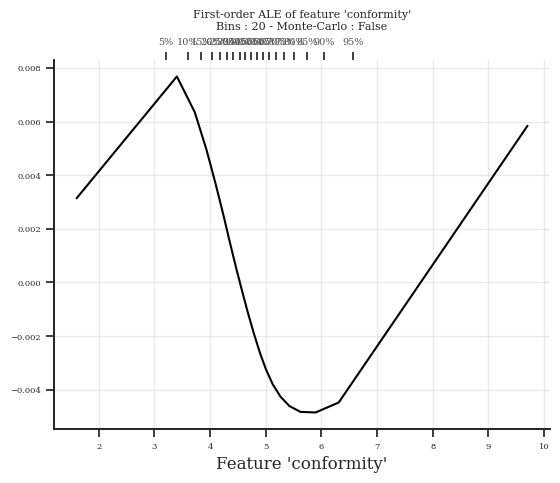

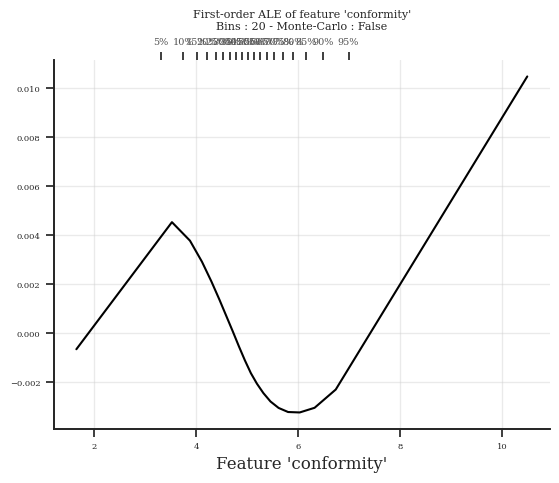

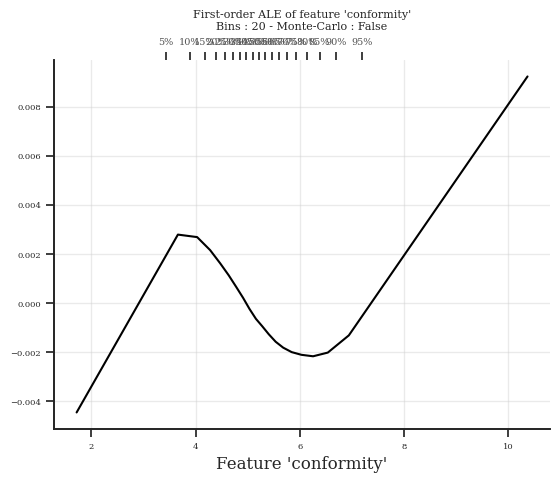

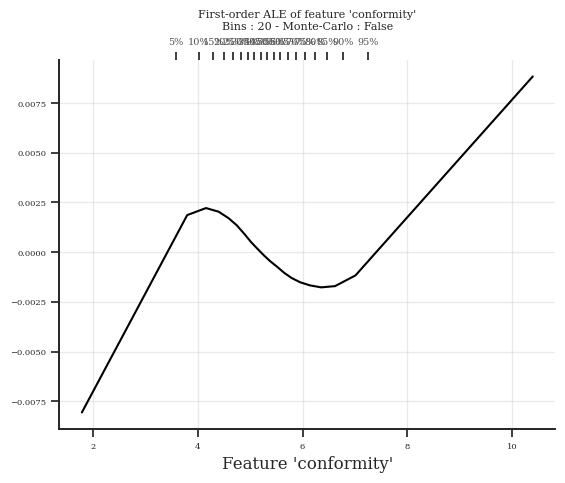

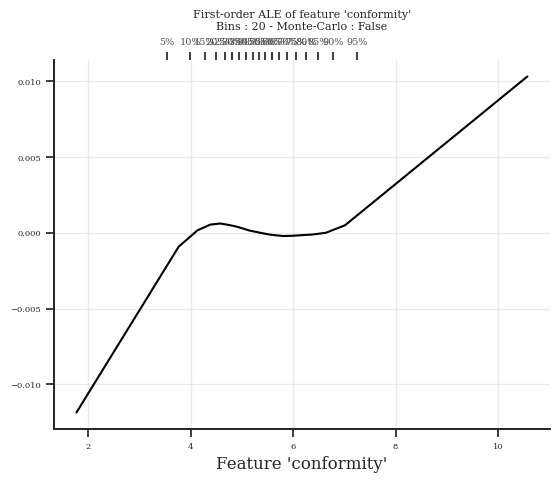

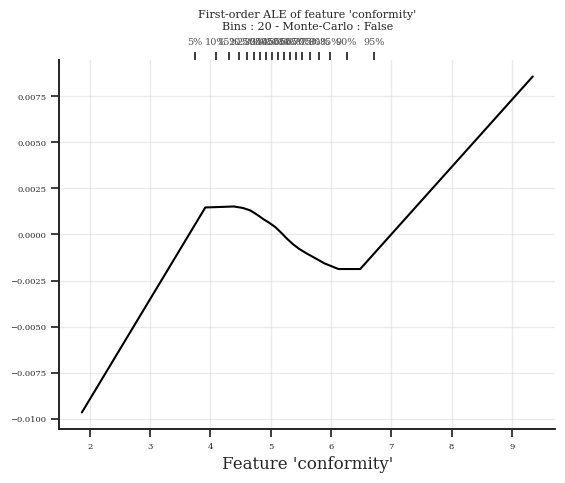

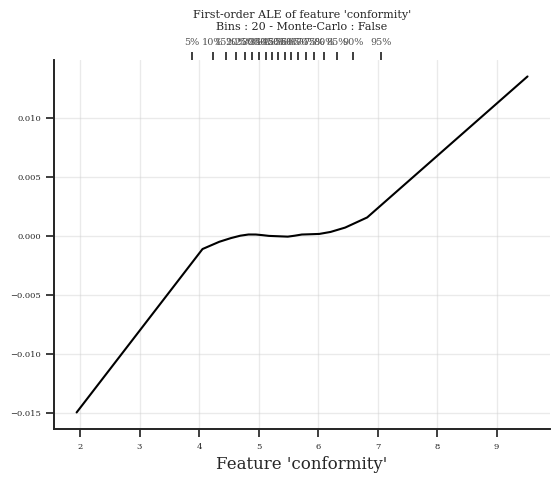

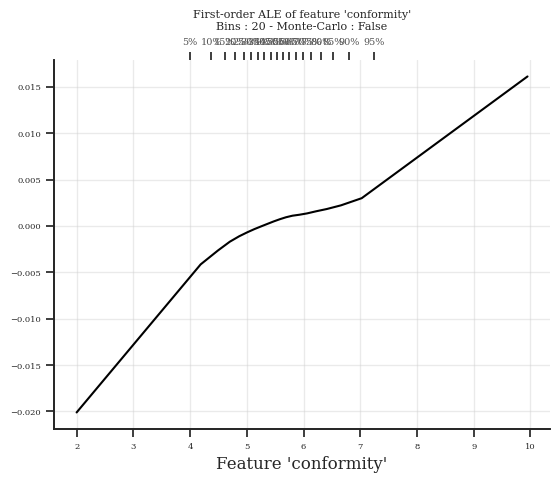

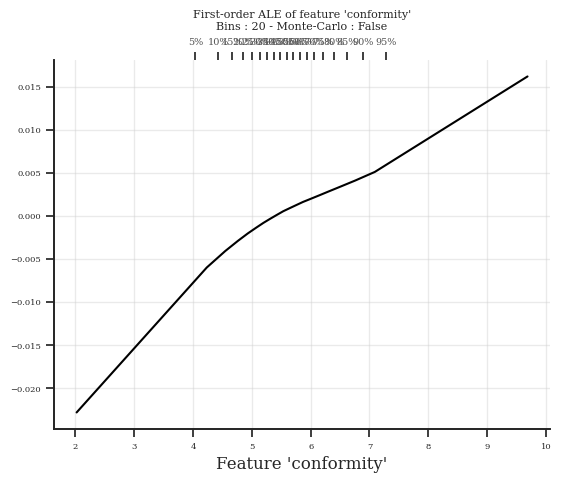

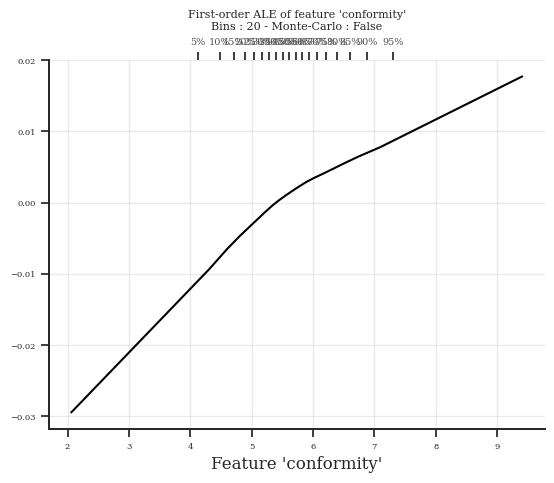

In [43]:
column_income = 2
ALE = []
for dataset in [dataset19, dataset23]:
    ale_list = []
    for income in range(5):
        dataset_subincome = obtain_dataset(dataset, column_income, selection=income)
        _, ale, _ = compute_ale(dataset_subincome, 'rmsn_' + str(exp_name), b_use_predicted_confounders=False, 
                                features=['conformity'], default_quantiles=default_quantiles)
        ale_list.append(ale)
    ALE.append(ale_list)

In [33]:
ALE_array = np.array(ALE)
ALE_array.shape

(2, 5, 20)

In [46]:
ALE_array = np.array(ALE)

min_vals = np.min(ALE_array, axis=2)
max_vals = np.max(ALE_array, axis=2)
ALER = np.stack((min_vals, max_vals), axis=2)

ALED = np.mean(np.abs(ALE_array), axis=2)

In [47]:
ALED

array([[0.00360854, 0.0025989 , 0.00204974, 0.00195904, 0.00136801],
       [0.00187792, 0.001688  , 0.00307683, 0.00403653, 0.00575715]])

In [39]:
ALER.shape

(2, 5, 2)

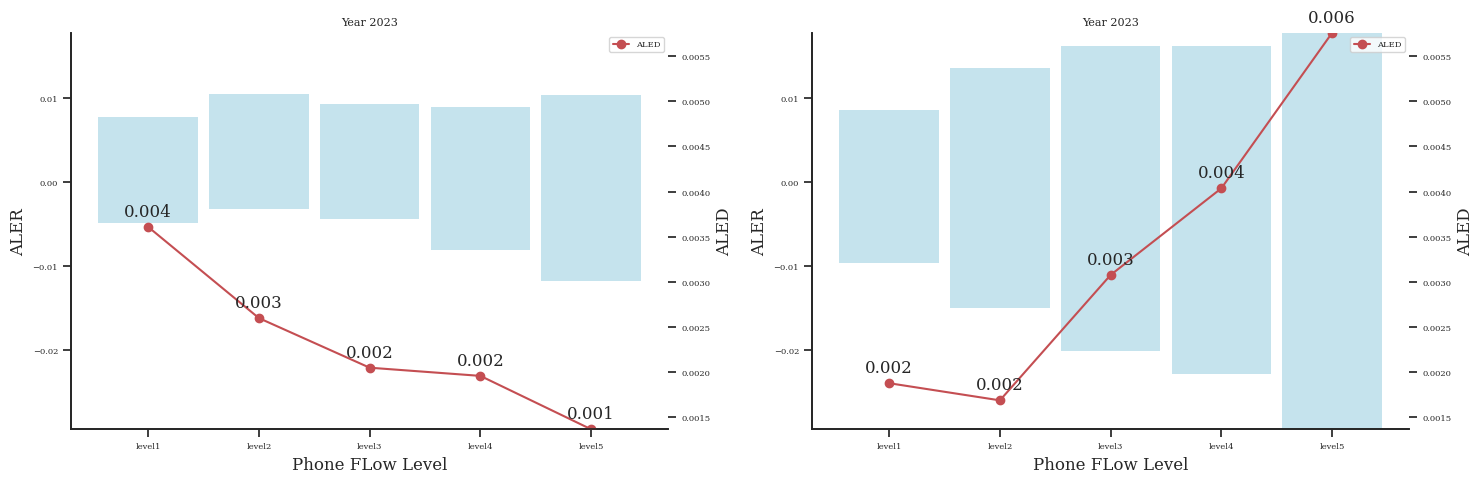

In [48]:
aler_min, aler_max = np.min(ALER), np.max(ALER)
aled_min, aled_max = np.min(ALED), np.max(ALED)

fig, axs = plt.subplots(1, ALED.shape[0], figsize=(15, 5))

# 循环遍历年份
for i in range(ALED.shape[0]):
    ax = axs[i]  # 指定每个子图

    # 获取相应年份的ALER和ALED数据
    aler = ALER[i, :, :]
    aled = ALED[i, :]

    # 绘制柱状图，纵向显示
    for i in range(aler.shape[0]):
        ax.bar(i, aler[i, 1] - aler[i, 0], bottom=aler[i, 0], width=0.9, color='lightblue', edgecolor='none', alpha=0.7)

    # 创建第二个y轴
    ax2 = ax.twinx()

    # 绘制ALED的折线图
    ax2.plot(range(len(aled)), aled, 'r-o', label='ALED')

    # 标注每个数据点
    for i, val in enumerate(aled):
        ax2.annotate(f'{val:.3f}', xy=(i, val), textcoords="offset points", xytext=(0,5), va='bottom', ha='center')

    # 设置图例
    ax2.legend(loc='upper right')

    # 设置标题
    ax.set_title(f'Year {2019 + j}')

    # 设置x轴标签
    ax.set_xticks(range(len(aled)))
    ax.set_xticklabels([f'level{i+1}' for i in range(len(aled))])
    
    ax.set_ylim(aler_min, aler_max)
    ax2.set_ylim(aled_min, aled_max)

    # 添加x轴和y轴标签
    ax.set_ylabel('ALER')
    ax2.set_ylabel('ALED')
    ax.set_xlabel('Phone FLow Level')

plt.tight_layout()  # 调整布局
plt.show()

## 连续变量（edu, married, density）

In [21]:
def _ax_title(ax, title, subtitle=""):
    ax.set_title("\n".join((title, subtitle)))


def _ax_labels(ax, xlabel=None, ylabel=None):
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)


def _ax_quantiles(ax, quantiles, twin="x"):
    if twin not in ("x", "y"):
        raise ValueError("'twin' should be one of 'x' or 'y'.")

    logger.debug("Quantiles: {}.", quantiles)

    # Duplicate the 'opposite' axis so we can define a distinct set of ticks for the
    # desired axis (`twin`).
    ax_mod = ax.twiny() if twin == "x" else ax.twinx()

    # Set the new axis' ticks for the desired axis.
    getattr(ax_mod, "set_{twin}ticks".format(twin=twin))(quantiles)
    # Set the corresponding tick labels.

    # Calculate tick label percentage values for each quantile (bin edge).
    # percentages = (
    #     100 * np.arange(len(quantiles), dtype=np.float64) / (len(quantiles) - 1)
    # )
    percentages = 5 + 90 * np.arange(len(quantiles), dtype=np.float64) / (len(quantiles) - 1)

    # If there is a fractional part, add a decimal place to show (part of) it.
    fractional = (~np.isclose(percentages % 1, 0)).astype("int8")

    getattr(ax_mod, "set_{twin}ticklabels".format(twin=twin))(
        [
            "{0:0.{1}f}%".format(percent, format_fraction)
            for percent, format_fraction in zip(percentages, fractional)
        ],
        color="#545454",
        fontsize=7,
    )
    getattr(ax_mod, "set_{twin}lim".format(twin=twin))(
        getattr(ax, "get_{twin}lim".format(twin=twin))()
    )

In [22]:
def _second_order_quant_plot(
    fig, ax, quantiles_list, ale, mark_empty=True, n_interp=50, **kwargs
):
    # define colormap - let value 0 equals white
    min_val = np.min(ale)
    max_val = np.max(ale)
    midpoint = abs(min_val) / (abs(max_val) + abs(min_val))
    colors = [(0, "blue"), (midpoint, "white"), (1, "red")]
    linear_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)
    
    centres_list = [_get_centres(quantiles) for quantiles in quantiles_list]
    print("plotting contour...")
    n_x, n_y = _check_two_ints(n_interp)
    x = np.linspace(centres_list[0][0], centres_list[0][-1], n_x)
    y = np.linspace(centres_list[1][0], centres_list[1][-1], n_y)

    X, Y = np.meshgrid(x, y, indexing="xy")
    ale_interp = scipy.interpolate.interp2d(centres_list[0], centres_list[1], ale.T)
    # CF = ax.contourf(X, Y, ale_interp(x, y), cmap="bwr", levels=30, alpha=0.7, **kwargs)
    CF = ax.contourf(X, Y, ale_interp(x, y), cmap=linear_cmap, vmin=min_val, vmax=max_val, levels=30, alpha=0.7, **kwargs)

    if mark_empty and np.any(ale.mask):
        # Do not autoscale, so that boxes at the edges (contourf only plots the bin
        # centres, not their edges) don't enlarge the plot.
        plt.autoscale(False)
        # Add rectangles to indicate cells without samples.
        for i, j in zip(*np.where(ale.mask)):
            ax.add_patch(
                Rectangle(
                    [quantiles_list[0][i], quantiles_list[1][j]],
                    quantiles_list[0][i + 1] - quantiles_list[0][i],
                    quantiles_list[1][j + 1] - quantiles_list[1][j],
                    linewidth=1,
                    edgecolor="k",
                    facecolor="none",
                    alpha=0.4,
                )
            )
    
    # fig.colorbar(CF)
    fig.colorbar(CF)

In [44]:
def compute_ale_2year(features):
    # 2019 ALE
    _, ale_19, quantiles_list_19 = compute_ale(dataset19, 'rmsn_' + str(exp_name), b_use_predicted_confounders=False, features=features)
    # 2023 ALE
    _, ale_23, quantiles_list_23 = compute_ale(dataset23, 'rmsn_' + str(exp_name), b_use_predicted_confounders=False, features=features)
    
    return ale_19, quantiles_list_19, ale_23, quantiles_list_23

In [45]:
def plot_2d_heatmap(features):
    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    years = ['2019','2023']

    # ax[0] - 2019
    for ale, quantiles_list, i in zip([ale_19, ale_23],[quantiles_list_19,quantiles_list_23],[0,1]):
        ale_filtered = ale[1:-1,1:-1]
        quantiles_list_filtered = [quantiles_list[0][1:-1], quantiles_list[1][1:-1]]
        _second_order_quant_plot(fig, ax[i], quantiles_list_filtered, ale_filtered)
        _ax_labels(
                        ax[i],
                        "Feature '{}'".format(features[0]),
                        "Feature '{}'".format(features[1]),
                        )

        for twin, quantiles in zip(("x", "y"), quantiles_list_19):
            _ax_quantiles(ax[i], quantiles[1:-1], twin=twin)

        _ax_title(
                        ax[i],
                        "Second-order ALE of features '{0}' and '{1}' in {2}".format(
                            features[0], features[1], years[i]
                        )
                 )

    plt.show()
    return fig, ax

In [ ]:
dataset = load_data("../data/sample_32w.h5")

column_2019 = 12  # index of year 2019 indicator
column_2023 = 14  # index of year 2023 indicator
dataset19 = obtain_dataset(dataset, column_2019)
dataset19 = dataset_sampling(dataset19, num_select=32000)
dataset23 = obtain_dataset(dataset, column_2023)
dataset23 = dataset_sampling(dataset23, num_select=32000)

del dataset; gc.collect()

In [ ]:
exp_name = "base_model_optimal_v2"

### density

2024-09-15 21:17:13.432 | DEBUG    | ale:_second_order_ale_quant:599 - Quantiles: (array([ 0.       ,  3.3952978,  3.8236969,  4.088964 ,  4.290041 ,
        4.456702 ,  4.6039243,  4.738389 ,  4.8663435,  4.989727 ,
        5.1119876,  5.236335 ,  5.364921 ,  5.504697 ,  5.6572633,
        5.8293724,  6.0305843,  6.27818  ,  6.5944133,  7.083677 ,
       13.553809 ], dtype=float32), array([  0.       ,   2.7725012,   6.362229 ,   9.709047 ,  12.588218 ,
        15.525198 ,  18.250835 ,  21.386494 ,  24.4985   ,  28.231878 ,
        31.430824 ,  35.24876  ,  39.129406 ,  42.798424 ,  46.758514 ,
        51.789406 ,  56.978592 ,  63.290394 ,  70.94873  ,  84.78755  ,
       148.87485  ], dtype=float32)).


(array([ 0.       ,  3.3952978,  3.8236969,  4.088964 ,  4.290041 ,
        4.456702 ,  4.6039243,  4.738389 ,  4.8663435,  4.989727 ,
        5.1119876,  5.236335 ,  5.364921 ,  5.504697 ,  5.6572633,
        5.8293724,  6.0305843,  6.27818  ,  6.5944133,  7.083677 ,
       13.553809 ], dtype=float32), array([  0.       ,   2.7725012,   6.362229 ,   9.709047 ,  12.588218 ,
        15.525198 ,  18.250835 ,  21.386494 ,  24.4985   ,  28.231878 ,
        31.430824 ,  35.24876  ,  39.129406 ,  42.798424 ,  46.758514 ,
        51.789406 ,  56.978592 ,  63.290394 ,  70.94873  ,  84.78755  ,
       148.87485  ], dtype=float32))
(20, 20)
results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 33.52it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 34.14it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 33.96it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 33.58it/s]
2024-09-15 21:18:30.410 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.3952978  3.8236969  4.088964   4.290041   4.456702
  4.6039243  4.738389   4.8663435  4.989727   5.1119876  5.236335
  5.364921   5.504697   5.6572633  5.8293724  6.0305843  6.27818
  6.5944133  7.083677  13.553809 ].
2024-09-15 21:18:30.442 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [  0.          2.7725012   6.362229    9.709047   12.588218   15.525198
  18.250835   21.386494   24.4985     28.231878   31.430824   35.24876
  39.129406   42.798424   46.758514   51.789406   56.978592   63.290394
  70.94873    84.78755   148.87485  ].


plotting contour...


2024-09-15 21:19:12.220 | DEBUG    | ale:_second_order_ale_quant:599 - Quantiles: (array([ 0.       ,  3.9440887,  4.304113 ,  4.5302567,  4.7034616,
        4.8486614,  4.979132 ,  5.099607 ,  5.212802 ,  5.3222227,
        5.4297614,  5.538382 ,  5.649443 ,  5.7666626,  5.8950014,
        6.0411572,  6.2159863,  6.4349422,  6.724724 ,  7.1779976,
       12.7279005], dtype=float32), array([  0.       ,   2.4535098,   6.2116966,   9.484001 ,  12.430701 ,
        15.510861 ,  18.260715 ,  21.6066   ,  24.531649 ,  28.051111 ,
        31.296072 ,  35.166595 ,  38.903896 ,  42.729275 ,  46.686977 ,
        51.827084 ,  56.978592 ,  63.385082 ,  70.70533  ,  84.39696  ,
       148.87485  ], dtype=float32)).


(array([ 0.       ,  3.9440887,  4.304113 ,  4.5302567,  4.7034616,
        4.8486614,  4.979132 ,  5.099607 ,  5.212802 ,  5.3222227,
        5.4297614,  5.538382 ,  5.649443 ,  5.7666626,  5.8950014,
        6.0411572,  6.2159863,  6.4349422,  6.724724 ,  7.1779976,
       12.7279005], dtype=float32), array([  0.       ,   2.4535098,   6.2116966,   9.484001 ,  12.430701 ,
        15.510861 ,  18.260715 ,  21.6066   ,  24.531649 ,  28.051111 ,
        31.296072 ,  35.166595 ,  38.903896 ,  42.729275 ,  46.686977 ,
        51.827084 ,  56.978592 ,  63.385082 ,  70.70533  ,  84.39696  ,
       148.87485  ], dtype=float32))
(20, 20)
results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 33.53it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 34.51it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:13, 35.91it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 34.33it/s]
2024-09-15 21:20:27.917 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.9440887  4.304113   4.5302567  4.7034616  4.8486614
  4.979132   5.099607   5.212802   5.3222227  5.4297614  5.538382
  5.649443   5.7666626  5.8950014  6.0411572  6.2159863  6.4349422
  6.724724   7.1779976 12.7279005].
2024-09-15 21:20:27.950 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [  0.          2.4535098   6.2116966   9.484001   12.430701   15.510861
  18.260715   21.6066     24.531649   28.051111   31.296072   35.166595
  38.903896   42.729275   46.686977   51.827084   56.978592   63.385082
  70.70533    84.39696   148.87485  ].


plotting contour...


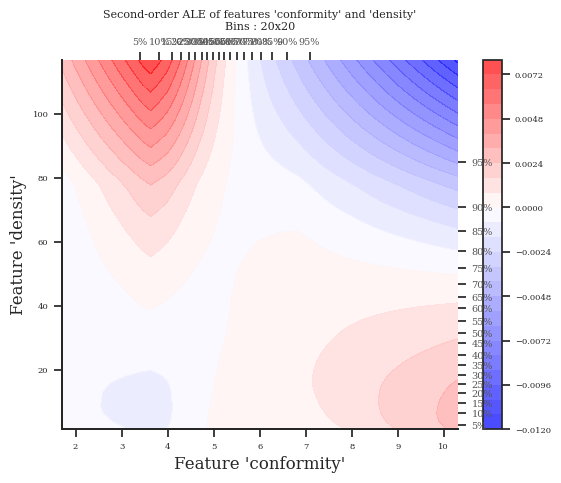

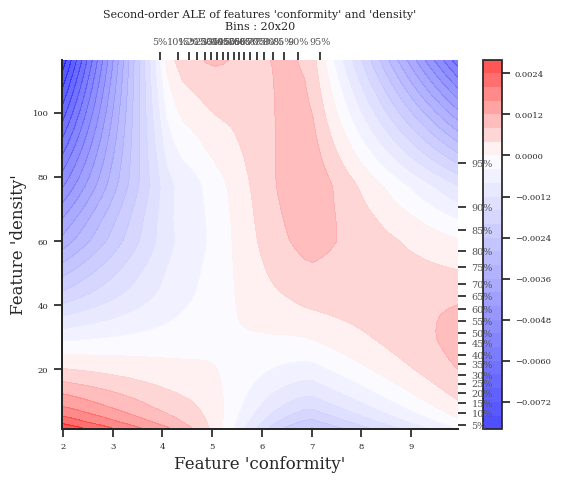

In [28]:
ale_19, quantiles_list_19, ale_23, quantiles_list_23 = compute_ale_2year(['conformity','density'])

plotting contour...


`interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

        `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see


plotting contour...


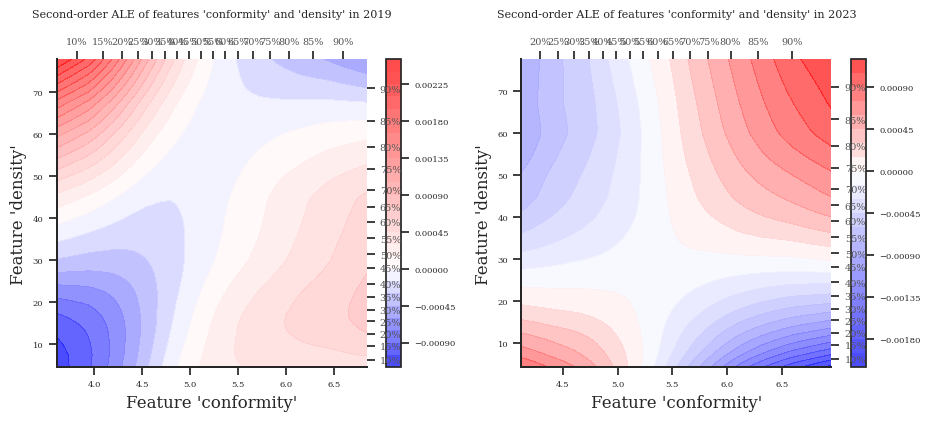

In [46]:
fig, ax = plot_2d_heatmap(['conformity','density'])

### edu

2024-09-15 21:28:07.845 | DEBUG    | ale:_second_order_ale_quant:599 - Quantiles: (array([ 0.       ,  3.3952978,  3.8236969,  4.088964 ,  4.290041 ,
        4.456702 ,  4.6039243,  4.738389 ,  4.8663435,  4.989727 ,
        5.1119876,  5.236335 ,  5.364921 ,  5.504697 ,  5.6572633,
        5.8293724,  6.0305843,  6.27818  ,  6.5944133,  7.083677 ,
       13.553809 ], dtype=float32), array([0.        , 0.0116815 , 0.02044688, 0.02878805, 0.03867754,
       0.04939314, 0.06175258, 0.07707424, 0.09750504, 0.11629348,
       0.13596949, 0.1539111 , 0.17455287, 0.1968621 , 0.21986456,
       0.24350384, 0.27000245, 0.30143166, 0.3374088 , 0.3932978 ,
       0.6626831 ], dtype=float32)).


(array([ 0.       ,  3.3952978,  3.8236969,  4.088964 ,  4.290041 ,
        4.456702 ,  4.6039243,  4.738389 ,  4.8663435,  4.989727 ,
        5.1119876,  5.236335 ,  5.364921 ,  5.504697 ,  5.6572633,
        5.8293724,  6.0305843,  6.27818  ,  6.5944133,  7.083677 ,
       13.553809 ], dtype=float32), array([0.        , 0.0116815 , 0.02044688, 0.02878805, 0.03867754,
       0.04939314, 0.06175258, 0.07707424, 0.09750504, 0.11629348,
       0.13596949, 0.1539111 , 0.17455287, 0.1968621 , 0.21986456,
       0.24350384, 0.27000245, 0.30143166, 0.3374088 , 0.3932978 ,
       0.6626831 ], dtype=float32))
(20, 20)
results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:20, 24.41it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:15, 32.65it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 33.86it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 34.58it/s]
2024-09-15 21:29:31.337 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.3952978  3.8236969  4.088964   4.290041   4.456702
  4.6039243  4.738389   4.8663435  4.989727   5.1119876  5.236335
  5.364921   5.504697   5.6572633  5.8293724  6.0305843  6.27818
  6.5944133  7.083677  13.553809 ].
2024-09-15 21:29:31.372 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [0.         0.0116815  0.02044688 0.02878805 0.03867754 0.04939314
 0.06175258 0.07707424 0.09750504 0.11629348 0.13596949 0.1539111
 0.17455287 0.1968621  0.21986456 0.24350384 0.27000245 0.30143166
 0.3374088  0.3932978  0.6626831 ].


plotting contour...


2024-09-15 21:30:12.923 | DEBUG    | ale:_second_order_ale_quant:599 - Quantiles: (array([ 0.       ,  3.9440887,  4.304113 ,  4.5302567,  4.7034616,
        4.8486614,  4.979132 ,  5.099607 ,  5.212802 ,  5.3222227,
        5.4297614,  5.538382 ,  5.649443 ,  5.7666626,  5.8950014,
        6.0411572,  6.2159863,  6.4349422,  6.724724 ,  7.1779976,
       12.7279005], dtype=float32), array([0.        , 0.01161861, 0.02002108, 0.02832847, 0.03845497,
       0.04932278, 0.06139954, 0.07689328, 0.09649843, 0.11603485,
       0.13489725, 0.1537602 , 0.17412908, 0.1968621 , 0.21986456,
       0.24376346, 0.26990777, 0.30316094, 0.3374088 , 0.3932978 ,
       0.6624904 ], dtype=float32)).


(array([ 0.       ,  3.9440887,  4.304113 ,  4.5302567,  4.7034616,
        4.8486614,  4.979132 ,  5.099607 ,  5.212802 ,  5.3222227,
        5.4297614,  5.538382 ,  5.649443 ,  5.7666626,  5.8950014,
        6.0411572,  6.2159863,  6.4349422,  6.724724 ,  7.1779976,
       12.7279005], dtype=float32), array([0.        , 0.01161861, 0.02002108, 0.02832847, 0.03845497,
       0.04932278, 0.06139954, 0.07689328, 0.09649843, 0.11603485,
       0.13489725, 0.1537602 , 0.17412908, 0.1968621 , 0.21986456,
       0.24376346, 0.26990777, 0.30316094, 0.3374088 , 0.3932978 ,
       0.6624904 ], dtype=float32))
(20, 20)
results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:15, 32.47it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 33.93it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 35.22it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 35.50it/s]
2024-09-15 21:31:29.152 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.9440887  4.304113   4.5302567  4.7034616  4.8486614
  4.979132   5.099607   5.212802   5.3222227  5.4297614  5.538382
  5.649443   5.7666626  5.8950014  6.0411572  6.2159863  6.4349422
  6.724724   7.1779976 12.7279005].
2024-09-15 21:31:29.189 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [0.         0.01161861 0.02002108 0.02832847 0.03845497 0.04932278
 0.06139954 0.07689328 0.09649843 0.11603485 0.13489725 0.1537602
 0.17412908 0.1968621  0.21986456 0.24376346 0.26990777 0.30316094
 0.3374088  0.3932978  0.6624904 ].


plotting contour...


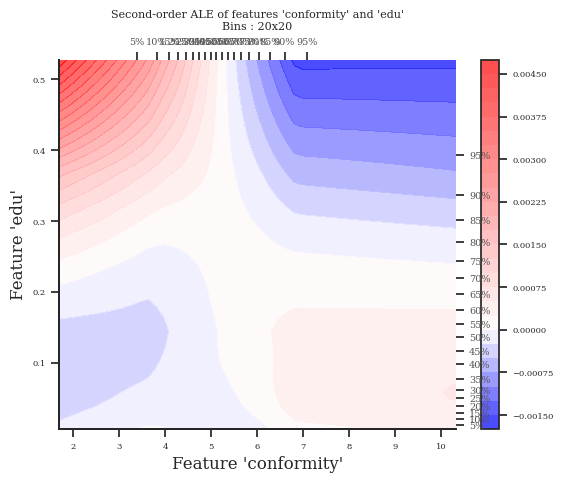

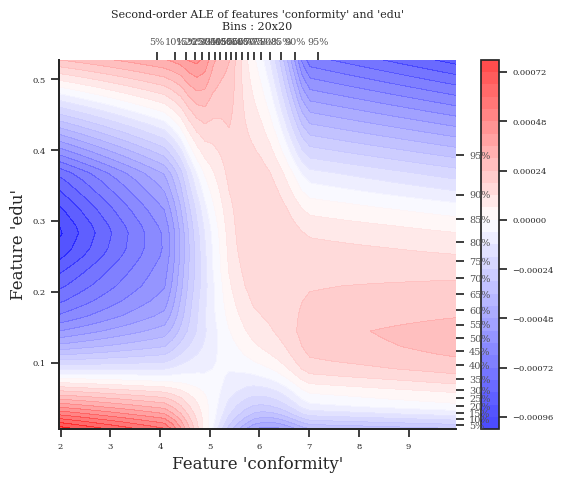

In [47]:
ale_19, quantiles_list_19, ale_23, quantiles_list_23 = compute_ale_2year(['conformity','edu'])

`interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

        `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see


plotting contour...
plotting contour...


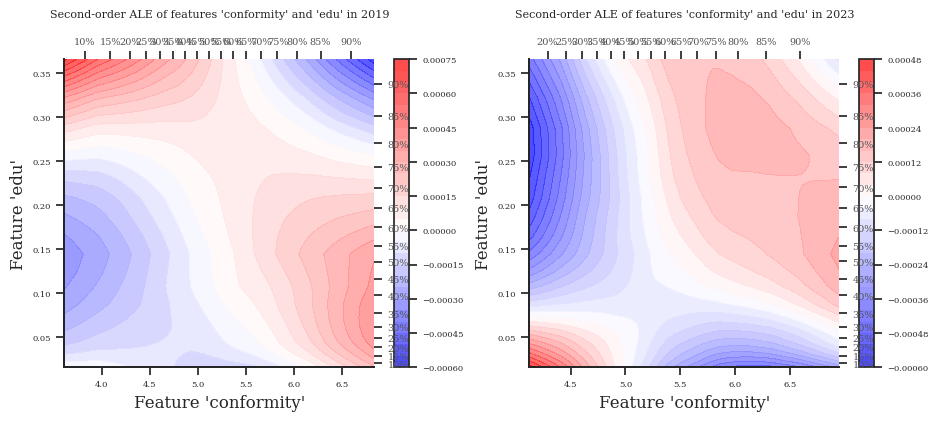

In [48]:
fig, ax = plot_2d_heatmap(['conformity','edu'])

### married

2024-09-15 21:32:14.010 | DEBUG    | ale:_second_order_ale_quant:599 - Quantiles: (array([ 0.       ,  3.3952978,  3.8236969,  4.088964 ,  4.290041 ,
        4.456702 ,  4.6039243,  4.738389 ,  4.8663435,  4.989727 ,
        5.1119876,  5.236335 ,  5.364921 ,  5.504697 ,  5.6572633,
        5.8293724,  6.0305843,  6.27818  ,  6.5944133,  7.083677 ,
       13.553809 ], dtype=float32), array([0.        , 0.20612657, 0.28552753, 0.33271328, 0.36454806,
       0.38674507, 0.4085109 , 0.4266042 , 0.4443068 , 0.45920524,
       0.4737446 , 0.48691726, 0.500257  , 0.51216716, 0.5240033 ,
       0.5364475 , 0.5495519 , 0.5622098 , 0.57846034, 0.6021064 ,
       0.74850935], dtype=float32)).


(array([ 0.       ,  3.3952978,  3.8236969,  4.088964 ,  4.290041 ,
        4.456702 ,  4.6039243,  4.738389 ,  4.8663435,  4.989727 ,
        5.1119876,  5.236335 ,  5.364921 ,  5.504697 ,  5.6572633,
        5.8293724,  6.0305843,  6.27818  ,  6.5944133,  7.083677 ,
       13.553809 ], dtype=float32), array([0.        , 0.20612657, 0.28552753, 0.33271328, 0.36454806,
       0.38674507, 0.4085109 , 0.4266042 , 0.4443068 , 0.45920524,
       0.4737446 , 0.48691726, 0.500257  , 0.51216716, 0.5240033 ,
       0.5364475 , 0.5495519 , 0.5622098 , 0.57846034, 0.6021064 ,
       0.74850935], dtype=float32))
(20, 20)
results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:15, 33.16it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:15, 33.14it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:15, 33.14it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 33.88it/s]
2024-09-15 21:33:34.133 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.3952978  3.8236969  4.088964   4.290041   4.456702
  4.6039243  4.738389   4.8663435  4.989727   5.1119876  5.236335
  5.364921   5.504697   5.6572633  5.8293724  6.0305843  6.27818
  6.5944133  7.083677  13.553809 ].
2024-09-15 21:33:34.171 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [0.         0.20612657 0.28552753 0.33271328 0.36454806 0.38674507
 0.4085109  0.4266042  0.4443068  0.45920524 0.4737446  0.48691726
 0.500257   0.51216716 0.5240033  0.5364475  0.5495519  0.5622098
 0.57846034 0.6021064  0.74850935].


plotting contour...


2024-09-15 21:34:16.414 | DEBUG    | ale:_second_order_ale_quant:599 - Quantiles: (array([ 0.       ,  3.9440887,  4.304113 ,  4.5302567,  4.7034616,
        4.8486614,  4.979132 ,  5.099607 ,  5.212802 ,  5.3222227,
        5.4297614,  5.538382 ,  5.649443 ,  5.7666626,  5.8950014,
        6.0411572,  6.2159863,  6.4349422,  6.724724 ,  7.1779976,
       12.7279005], dtype=float32), array([0.        , 0.2044724 , 0.2858928 , 0.33271328, 0.36454806,
       0.38686588, 0.4092199 , 0.42743647, 0.44403183, 0.45793694,
       0.4735491 , 0.48625875, 0.49935907, 0.5114657 , 0.5228137 ,
       0.53615075, 0.549582  , 0.5620745 , 0.5790051 , 0.6021064 ,
       0.7548449 ], dtype=float32)).


(array([ 0.       ,  3.9440887,  4.304113 ,  4.5302567,  4.7034616,
        4.8486614,  4.979132 ,  5.099607 ,  5.212802 ,  5.3222227,
        5.4297614,  5.538382 ,  5.649443 ,  5.7666626,  5.8950014,
        6.0411572,  6.2159863,  6.4349422,  6.724724 ,  7.1779976,
       12.7279005], dtype=float32), array([0.        , 0.2044724 , 0.2858928 , 0.33271328, 0.36454806,
       0.38686588, 0.4092199 , 0.42743647, 0.44403183, 0.45793694,
       0.4735491 , 0.48625875, 0.49935907, 0.5114657 , 0.5228137 ,
       0.53615075, 0.549582  , 0.5620745 , 0.5790051 , 0.6021064 ,
       0.7548449 ], dtype=float32))
(20, 20)
results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:15, 32.98it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 34.94it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 34.77it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 500it [00:14, 35.31it/s]
2024-09-15 21:35:32.675 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.9440887  4.304113   4.5302567  4.7034616  4.8486614
  4.979132   5.099607   5.212802   5.3222227  5.4297614  5.538382
  5.649443   5.7666626  5.8950014  6.0411572  6.2159863  6.4349422
  6.724724   7.1779976 12.7279005].
2024-09-15 21:35:32.707 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [0.         0.2044724  0.2858928  0.33271328 0.36454806 0.38686588
 0.4092199  0.42743647 0.44403183 0.45793694 0.4735491  0.48625875
 0.49935907 0.5114657  0.5228137  0.53615075 0.549582   0.5620745
 0.5790051  0.6021064  0.7548449 ].


plotting contour...


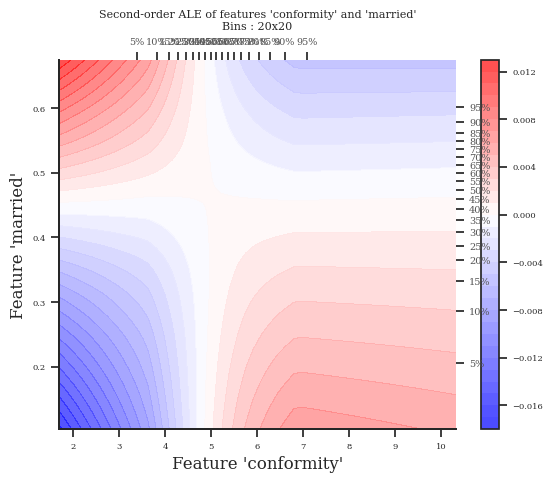

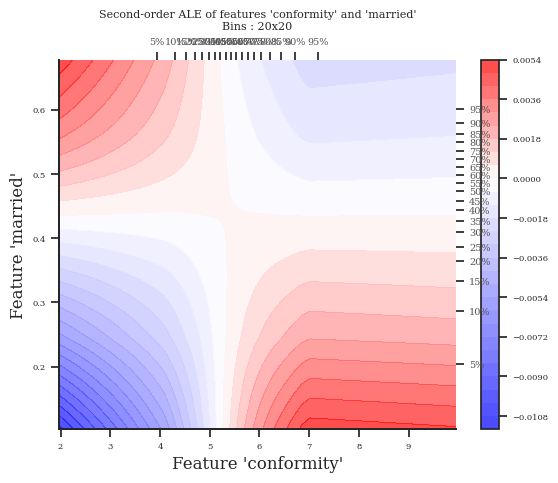

In [49]:
ale_19, quantiles_list_19, ale_23, quantiles_list_23 = compute_ale_2year(['conformity','married'])

`interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

        `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see


plotting contour...
plotting contour...


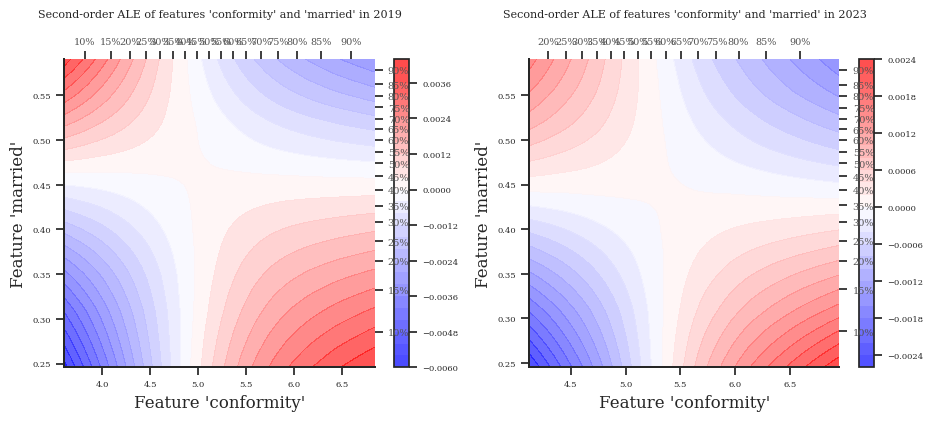

In [50]:
fig, ax = plot_2d_heatmap(['conformity','married'])

## Ice

In [4]:
# 选取一定样本，对个体计算ale
def select_indiviudal_from_dataset(dataset, index, overall=32000):
    indiv_indices = [index, overall+index, overall*2 + index]
    indiv_dataset = {key: value[indiv_indices] for key, value in dataset.items()}
    return indiv_dataset

In [5]:
def construct_relevant_dataframe(dataset, model_name, b_use_predicted_confounders,):
    model_name = model_name + '_use_confounders_' + str(b_use_predicted_confounders)
    model_root = os.path.join('results', model_name)
    config = {'covariate_cols':['gender','age','income','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
           'voluntary','festivals','year_0','year_1','year_2','edu','married','dist_yes','density',
                           'temperature','percipit','E1','E2'],
            'treatment_cols':['conformity'],
             }
    
    # shape of data
    num_samples, length, num_covariates = dataset['covariates'].shape
    _, _, num_treatments = dataset['treatments'].shape
    num_years = 3
    FE_predict = Feature_Engineering(dataset, for_factor_model = False)
    X = FE_predict.construct_dataframe(config)
    dataset['output_means'] = FE_predict.scale_params['outcomes'][:, 0]
    dataset['output_stds'] = FE_predict.scale_params['outcomes'][:, 1]
    # add timeline and week column
    X['timeline'] = np.tile(np.arange(length), num_samples)
    start_date = pd.Timestamp('2019-12-21')
    X['date'] = X['timeline'].apply(lambda x: start_date + pd.Timedelta(days=x))
    X['week'] = ((X['date'] - start_date).dt.days / 7).astype(int)
    X['pid'] = np.repeat(np.arange(int(num_samples/3)), length*3)
    
    # ############################################################################################
    def ale_use_predict(X, dataset, config, model_root, FE_predict, b_use_predicted_confounders):
        # change data
        mod_dataset = dataset.copy()
        # 将修改完的值添加到mod_dataset
        covariate_shapes = dataset['covariates'].shape
        mod_dataset['covariates'] = X[config['covariate_cols']].values.reshape(covariate_shapes[0],covariate_shapes[1],covariate_shapes[2])
        treatment_shapes = dataset['treatments'].shape
        mod_dataset['treatments'] = X[config['treatment_cols']].values.reshape(treatment_shapes[0],treatment_shapes[1],treatment_shapes[2])

        # 使用原来的参数做标准化
        mod_dataset = FE_predict.get_dataset_normalize(mod_dataset, num_covariates, num_treatments)
        # 调用函数预测
        predictions, _ = \
        rnn_predict(dataset=mod_dataset, MODEL_ROOT=model_root,
                    b_use_predicted_confounders=b_use_predicted_confounders)
        outputs = predictions.reshape(-1)
        del mod_dataset; gc.collect()
        return outputs
    # ############################################################################################
    # define predictor
    predictor = lambda x: ale_use_predict(x, dataset, config, model_root, FE_predict, b_use_predicted_confounders)
    
    return X, predictor

In [6]:
def compute_ice(predictor, train_set, features, bins, default_quantiles=None):
    
    if len(features) != 2:
        raise ValueError(
            "'features' contained '{n_feat}' features. Expected 2.".format(
                n_feat=len(features)
            )
        )
    # if compute time-varying ALE, use first order quant, divide into 2 conditions: week or sliding windows
    # extract a part of code from _first_order_ale_quant and modify##########################
    feature = [feature for feature in features if feature != "week"][0]
    # feature = 'conformity'
    if default_quantiles is None:
        quantiles, real_bins = _get_quantiles(train_set, feature, bins)
    else:
        quantiles, real_bins = default_quantiles, len(default_quantiles) - 1
    # adjust week to match index
    #adjusted_weeks_list = [week - 1 for week in sorted(train_set['week'].unique())]
    quantiles_list = tuple(np.append(sorted(train_set['week'].unique()), max(train_set['week'])+1) if f=='week' else quantiles for f in features)
    bins_list = tuple(len(train_set['week'].unique()) if f=='week' else real_bins for f in features)
    logger.debug("Quantiles: {}.", quantiles)

    num_quantiles = len(quantiles)
    num_samples = len(train_set)
    predictions = np.zeros((num_quantiles, num_samples))

    # 遍历每个 week替换特征值
    for week in sorted(train_set['week'].unique()):
        # 筛选出对应 week 的数据行
        week_indices = train_set['week'] == week
        # feature_indices = np.clip(
        #     np.digitize(train_set[week_indices][feature], quantiles, right=True) - 1, 0, None
        #     )
        # 对每个个体的数据都换成bins去预测（类似pdp的做法）
        for i in range(num_quantiles):
            # 复制整个训练集
            mod_train_set = train_set.copy()
            # 只更新当前 week 的特定特征值
            mod_train_set.loc[week_indices, feature] = quantiles[i]
            # 对整个训练集进行预测并记录
            predictions[i][week_indices] = predictor(mod_train_set)[week_indices]

            del mod_train_set; gc.collect()

    effects = np.diff(predictions, axis=0)

    # 获取每个样本的分位数位置
    indices = np.zeros((num_samples, num_quantiles - 1))

    for i in range(num_samples):
        indices[i] = (np.arange(num_quantiles - 1)).astype("int")

    indiv_groups = pd.DataFrame(
        {"pid": train_set["pid"].values.repeat(num_quantiles - 1), 
         "time": train_set["week"].values.repeat(num_quantiles - 1), 
         "index": indices.flatten(), 
         "effects": effects.flatten()}
    )
    
    return effects, indiv_groups

In [6]:
def compute_ice(predictor, train_set, feature, bins, default_quantiles=None):
    
    if default_quantiles is None:
        quantiles, real_bins = _get_quantiles(train_set, feature, bins)
    else:
        quantiles, real_bins = default_quantiles, len(default_quantiles) - 1
    # adjust week to match index
    #adjusted_weeks_list = [week - 1 for week in sorted(train_set['week'].unique())]

    num_quantiles = len(quantiles)
    num_samples = len(train_set)
    predictions = np.zeros((num_quantiles, num_samples))

    # 对每个个体的数据都换成bins去预测（类似pdp的做法）
    for i in range(num_quantiles):
        # 复制整个训练集
        mod_train_set = train_set.copy()
        # 只更新当前 week 的特定特征值
        mod_train_set[feature] = quantiles[i]
        # 对整个训练集进行预测并记录
        predictions[i] = predictor(mod_train_set)

        del mod_train_set; gc.collect()

    effects = np.diff(predictions, axis=0)

    # 获取每个样本的分位数位置
    indices = np.zeros((num_samples, num_quantiles - 1))

    for i in range(num_samples):
        indices[i] = (np.arange(num_quantiles - 1)).astype("int")

    indiv_groups = pd.DataFrame(
        {"pid": train_set["pid"].values.repeat(num_quantiles - 1),  
         "index": indices.flatten(), 
         "effects": effects.flatten()}
    )
    
    ale_list = []
    for _, group in indiv_groups.groupby("pid"):
        mean_effects = group.groupby("index")["effects"].mean().to_numpy().flatten()
        ale = np.array([0, *np.cumsum(mean_effects)])
        ale = _get_centres(ale)
        ale -= np.mean(ale)
        ale_list.append(ale)
        
    return np.array(ale_list)

In [16]:
def create_ice_dataset(ice_dict, quantiles, model_names, feature_name):
  
    # quantiles取平均
    quantiles = (quantiles[:-1] + quantiles[1:]) / 2

    # 创建data_vars字典
    data_vars = {}
    for model_name in model_names:
        ice = ice_dict[model_name]
        # 如果 ale 是一维数组，则添加一个维度
        if ice.ndim == 1:
            ice = ice[np.newaxis, :]
        
        data_vars[f"{feature_name}__{model_name}__ice"] = (["n_bootstrap", f"n_bins__{feature_name}"], ice)

    data_vars[f"{feature_name}__bin_values"] = ([f"n_bins__{feature_name}"], quantiles)

    # 创建 xarray.Dataset
    dataset = xr.Dataset(
        data_vars=data_vars,
        attrs={
            "estimator_output": "raw",
            "estimators used": model_names,
            "method": "ale",
            "dimension": "1D",
            "features used": [feature_name],
        }
    )
    
    # === 新增部分：提取 first_values 并添加到 X_sampled 和 features 中 ===
    # 提取 'conformity__RNN_Model__ice' 中每条 ICE 曲线的第一个值
    first_values = dataset[f"{feature_name}__{model_name}__ice"].values[:, 0]

    # 将 first_values 转换为 X_sampled 格式
    X_sampled = np.expand_dims(first_values, axis=1)  # 将一维数组转换为二维数组

    # 将 X_sampled 和 features 添加到数据集
    dataset = dataset.assign(X_sampled=(['n_bootstrap', 'feature'], X_sampled))
    dataset = dataset.assign(features=(['feature'], ['first_values']))

    return dataset

In [8]:
dataset = load_data("../data/sample_32w_add.h5")
# dataset = load_data("../data/sample_32w.h5")

index_to_remove = dataset['covariates'].shape[2] - 5
dataset['covariates'] = np.delete(dataset['covariates'], index_to_remove, axis=2)

index_to_remove = dataset['covariates'].shape[2] - 5
dataset['covariates'] = np.delete(dataset['covariates'], index_to_remove, axis=2)

for key in dataset.keys():
    print(key)
    print(dataset[key].shape)
    print(dataset[key].dtype)

covariates
(981651, 161, 23)
float32
outcomes
(981651, 161, 1)
float32
sequence_length
(981651,)
int64
treatments
(981651, 161, 1)
float32


In [9]:
bins = 20
quantiles = np.unique(
   np.quantile(
       dataset['treatments'].reshape(-1), np.linspace(0, 1, bins + 1), interpolation="lower"
   )
)

the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


In [10]:
column_2019 = 12  # index of year 2019 indicator
column_2023 = 14  # index of year 2023 indicator
dataset19 = obtain_dataset(dataset, column_2019)
dataset19_sample = dataset_sampling(dataset19, num_select=32000)

dataset23 = obtain_dataset(dataset, column_2023)
dataset23_sample = dataset_sampling(dataset23, num_select=32000)

del dataset; gc.collect()

0

In [11]:
exp_name = "base_model_optimal_v2"

#### ale dataset

2024-09-15 17:27:56.899 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.4315217  3.8435144  4.108434   4.3068094  4.478317
  4.6277924  4.760166   4.8859134  5.0066032  5.124377   5.2484074
  5.3702517  5.511022   5.667198   5.829914   6.0258775  6.265433
  6.5804777  7.115206  13.246157 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 0it [00:00, ?it/s]2024-09-15 17:27:58.416567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
Predicting rnn_propensity_weighted: 16it [00:01, 13.79it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.23it/s]
2024-09-15 17:28:01.687 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.4315217  3.8435144  4.108434   4.3068094  4.478317
  4.6277924  4.760166   4.8859134  5.0066032  5.124377   5.2484074
  5.3702517  5.511022   5.667198   5.829914   6.0258775  6.265433
  6.5804777  7.115206  13.246157 ].


[ 1.7157608  3.637518   3.9759743  4.2076216  4.392563   4.553055
  4.6939793  4.82304    4.9462585  5.06549    5.186392   5.3093295
  5.4406366  5.5891104  5.748556   5.9278955  6.145655   6.4229555
  6.8478417 10.180681 ]


2024-09-15 17:28:03.069 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.38292    3.8126068  4.0716124  4.2637606  4.4331064
  4.5832753  4.7239666  4.8487544  4.974835   5.0919843  5.211398
  5.336291   5.479436   5.62468    5.800108   6.0020614  6.2476544
  6.5760055  7.099413  12.322993 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 14.87it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 14.75it/s]
2024-09-15 17:28:07.490 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.38292    3.8126068  4.0716124  4.2637606  4.4331064
  4.5832753  4.7239666  4.8487544  4.974835   5.0919843  5.211398
  5.336291   5.479436   5.62468    5.800108   6.0020614  6.2476544
  6.5760055  7.099413  12.322993 ].


[1.69146   3.5977635 3.9421096 4.1676865 4.3484335 4.508191  4.6536207
 4.7863607 4.9117947 5.0334096 5.1516914 5.2738447 5.4078636 5.552058
 5.7123938 5.901085  6.124858  6.41183   6.8377094 9.711203 ]


2024-09-15 17:28:08.929 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.4268897  3.8720555  4.1405997  4.3377805  4.500784
  4.6480503  4.777998   4.902312   5.0192256  5.135287   5.252948
  5.379355   5.516214   5.6719174  5.8427196  6.0502167  6.294938
  6.612492   7.0871844 13.4767475].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.10it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 14.49it/s]
2024-09-15 17:28:13.315 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.4268897  3.8720555  4.1405997  4.3377805  4.500784
  4.6480503  4.777998   4.902312   5.0192256  5.135287   5.252948
  5.379355   5.516214   5.6719174  5.8427196  6.0502167  6.294938
  6.612492   7.0871844 13.4767475].


[ 1.7134448  3.6494727  4.0063276  4.23919    4.419282   4.574417
  4.713024   4.8401546  4.9607687  5.077256   5.1941175  5.3161516
  5.4477844  5.5940657  5.7573185  5.9464684  6.1725774  6.4537153
  6.8498383 10.281966 ]


2024-09-15 17:28:14.697 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.3854618  3.820702   4.082112   4.286493   4.4585576
  4.61081    4.7459416  4.873891   4.992186   5.1114883  5.2296076
  5.3532777  5.4958596  5.650312   5.827793   6.0186186  6.273855
  6.602135   7.1172037 12.331828 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 14.38it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 13.94it/s]
2024-09-15 17:28:19.415 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.3854618  3.820702   4.082112   4.286493   4.4585576
  4.61081    4.7459416  4.873891   4.992186   5.1114883  5.2296076
  5.3532777  5.4958596  5.650312   5.827793   6.0186186  6.273855
  6.602135   7.1172037 12.331828 ].


[1.6927309 3.603082  3.951407  4.1843023 4.372525  4.5346837 4.6783757
 4.8099165 4.9330387 5.051837  5.170548  5.291443  5.4245687 5.573086
 5.739053  5.923206  6.146237  6.437995  6.8596697 9.724516 ]


2024-09-15 17:28:20.732 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.4092941  3.8590212  4.124375   4.325158   4.4883385
  4.629705   4.7626686  4.891277   5.0110874  5.13068    5.2534466
  5.382581   5.5184617  5.665766   5.8351126  6.031659   6.27123
  6.5986376  7.0731297 13.20138  ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.06it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.13it/s]
2024-09-15 17:28:25.033 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.4092941  3.8590212  4.124375   4.325158   4.4883385
  4.629705   4.7626686  4.891277   5.0110874  5.13068    5.2534466
  5.382581   5.5184617  5.665766   5.8351126  6.031659   6.27123
  6.5986376  7.0731297 13.20138  ].


[ 1.7046471  3.6341577  3.991698   4.2247667  4.4067483  4.559022
  4.696187   4.826973   4.9511824  5.0708838  5.1920633  5.318014
  5.4505215  5.5921135  5.750439   5.933386   6.1514444  6.4349337
  6.8358836 10.137255 ]


2024-09-15 17:28:26.427 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.3876557  3.8135798  4.0787115  4.275641   4.449395
  4.594056   4.731803   4.858456   4.9861436  5.1079636  5.2440343
  5.3836327  5.531282   5.683055   5.8613777  6.063785   6.3108597
  6.611957   7.0952477 12.952929 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 17.28it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.11it/s]
2024-09-15 17:28:30.757 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.3876557  3.8135798  4.0787115  4.275641   4.449395
  4.594056   4.731803   4.858456   4.9861436  5.1079636  5.2440343
  5.3836327  5.531282   5.683055   5.8613777  6.063785   6.3108597
  6.611957   7.0952477 12.952929 ].


[ 1.6938279  3.600618   3.9461455  4.1771765  4.3625183  4.5217257
  4.6629295  4.79513    4.9223     5.0470533  5.1759987  5.313833
  5.4574575  5.607168   5.7722163  5.9625816  6.1873226  6.4614086
  6.8536024 10.024088 ]


2024-09-15 17:28:32.104 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.4297338  3.8357105  4.0954933  4.2966666  4.4669294
  4.6106505  4.7448945  4.8658323  4.984294   5.1047764  5.2266974
  5.3564205  5.494706   5.6503158  5.8327856  6.023102   6.2718067
  6.584184   7.054136  13.339281 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.22it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.47it/s]
2024-09-15 17:28:36.450 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.4297338  3.8357105  4.0954933  4.2966666  4.4669294
  4.6106505  4.7448945  4.8658323  4.984294   5.1047764  5.2266974
  5.3564205  5.494706   5.6503158  5.8327856  6.023102   6.2718067
  6.584184   7.054136  13.339281 ].


[ 1.7148669  3.6327221  3.965602   4.19608    4.381798   4.5387897
  4.6777725  4.8053637  4.925063   5.044535   5.165737   5.291559
  5.4255633  5.5725107  5.7415504  5.9279437  6.1474543  6.4279957
  6.81916   10.196709 ]


2024-09-15 17:28:37.690 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.3587434  3.8173332  4.092522   4.291329   4.45325
  4.5953884  4.731803   4.8583436  4.9788585  5.1006975  5.223425
  5.3548     5.496484   5.648138   5.822388   6.014345   6.253674
  6.56707    7.0681458 14.007114 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.79it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.34it/s]
2024-09-15 17:28:42.241 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.3587434  3.8173332  4.092522   4.291329   4.45325
  4.5953884  4.731803   4.8583436  4.9788585  5.1006975  5.223425
  5.3548     5.496484   5.648138   5.822388   6.014345   6.253674
  6.56707    7.0681458 14.007114 ].


[ 1.6793717  3.5880384  3.9549277  4.1919255  4.3722897  4.524319
  4.6635957  4.7950735  4.918601   5.0397778  5.162061   5.2891126
  5.425642   5.572311   5.735263   5.9183664  6.1340094  6.410372
  6.817608  10.53763  ]


2024-09-15 17:28:43.602 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.418242   3.83712    4.1060405  4.3085594  4.47702
  4.626295   4.7581024  4.883652   5.0084577  5.128006   5.253246
  5.383746   5.523756   5.6737266  5.8355713  6.029633   6.2803917
  6.594836   7.08654   13.99272  ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 17.12it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.62it/s]
2024-09-15 17:28:47.935 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.418242   3.83712    4.1060405  4.3085594  4.47702
  4.626295   4.7581024  4.883652   5.0084577  5.128006   5.253246
  5.383746   5.523756   5.6737266  5.8355713  6.029633   6.2803917
  6.594836   7.08654   13.99272  ].


[ 1.709121   3.627681   3.9715803  4.2073     4.39279    4.5516577
  4.6921988  4.820877   4.946055   5.0682316  5.190626   5.3184958
  5.453751   5.5987415  5.754649   5.932602   6.155012   6.437614
  6.840688  10.53963  ]


2024-09-15 17:28:49.379 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.         3.4195197  3.8441725  4.1180434  4.321501   4.487067
  4.632162   4.7665815  4.889877   5.006799   5.1244855  5.243239
  5.363809   5.499163   5.647525   5.8184004  6.005887   6.246077
  6.546443   6.999952  13.225048 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.92it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 17.19it/s]
2024-09-15 17:28:53.773 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.         3.4195197  3.8441725  4.1180434  4.321501   4.487067
  4.632162   4.7665815  4.889877   5.006799   5.1244855  5.243239
  5.363809   5.499163   5.647525   5.8184004  6.005887   6.246077
  6.546443   6.999952  13.225048 ].


[ 1.7097598  3.631846   3.981108   4.2197723  4.404284   4.5596147
  4.699372   4.828229   4.948338   5.0656424  5.183862   5.303524
  5.431486   5.573344   5.7329626  5.9121437  6.1259823  6.3962603
  6.773197  10.1125   ]


2024-09-15 17:28:55.396 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.10840935  3.8863935   4.267961    4.505455    4.690817    4.8514013
  4.9863253   5.1045303   5.2184176   5.329859    5.4448977   5.559327
  5.6687307   5.7786913   5.901469    6.0414877   6.215319    6.4382
  6.756578    7.186387   11.945429  ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.43it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.95it/s]
2024-09-15 17:28:59.914 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.10840935  3.8863935   4.267961    4.505455    4.690817    4.8514013
  4.9863253   5.1045303   5.2184176   5.329859    5.4448977   5.559327
  5.6687307   5.7786913   5.901469    6.0414877   6.215319    6.4382
  6.756578    7.186387   11.945429  ].


[1.9974015 4.077177  4.3867083 4.598136  4.771109  4.9188633 5.045428
 5.161474  5.2741385 5.387378  5.5021124 5.614029  5.723711  5.8400803
 5.9714785 6.1284037 6.3267593 6.597389  6.9714823 9.565908 ]


2024-09-15 17:29:01.435 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.06509888  3.9483812   4.3114305   4.5225058   4.6912704   4.8402996
  4.976381    5.098184    5.2106566   5.318965    5.4267645   5.545054
  5.661216    5.786608    5.918262    6.062781    6.240376    6.477475
  6.7730336   7.2551475  12.087632  ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.67it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 14.42it/s]
2024-09-15 17:29:06.032 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.06509888  3.9483812   4.3114305   4.5225058   4.6912704   4.8402996
  4.976381    5.098184    5.2106566   5.318965    5.4267645   5.545054
  5.661216    5.786608    5.918262    6.062781    6.240376    6.477475
  6.7730336   7.2551475  12.087632  ].


[2.00674   4.1299057 4.4169683 4.606888  4.765785  4.9083405 5.0372825
 5.1544204 5.2648106 5.3728647 5.4859095 5.603135  5.7239122 5.852435
 5.9905214 6.1515784 6.358926  6.6252546 7.0140905 9.67139  ]


2024-09-15 17:29:07.448 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.4626236  3.9996269  4.352997   4.562067   4.7213945  4.859005
  4.982794   5.0982103  5.212141   5.3181834  5.430869   5.539964
  5.6510983  5.7667394  5.898487   6.0504894  6.2494664  6.4717865
  6.7473383  7.2015963 11.686467 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.38it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.03it/s]
2024-09-15 17:29:11.888 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.4626236  3.9996269  4.352997   4.562067   4.7213945  4.859005
  4.982794   5.0982103  5.212141   5.3181834  5.430869   5.539964
  5.6510983  5.7667394  5.898487   6.0504894  6.2494664  6.4717865
  6.7473383  7.2015963 11.686467 ].


[2.2311254 4.176312  4.457532  4.641731  4.7901998 4.9208994 5.040502
 5.1551757 5.2651625 5.374526  5.4854164 5.5955315 5.7089186 5.832613
 5.9744883 6.1499777 6.360626  6.6095624 6.9744673 9.444032 ]


2024-09-15 17:29:13.243 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.06013836  3.94204     4.2955575   4.5298266   4.7036915   4.851429
  4.976604    5.090024    5.1979136   5.3015304   5.4018564   5.5074983
  5.612805    5.730018    5.8500786   5.9971013   6.173478    6.401952
  6.6889014   7.119001   10.886707  ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 13.63it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.02it/s]
2024-09-15 17:29:17.930 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.06013836  3.94204     4.2955575   4.5298266   4.7036915   4.851429
  4.976604    5.090024    5.1979136   5.3015304   5.4018564   5.5074983
  5.612805    5.730018    5.8500786   5.9971013   6.173478    6.401952
  6.6889014   7.119001   10.886707  ].


[2.001089  4.1187987 4.412692  4.6167593 4.77756   4.9140167 5.0333138
 5.1439686 5.249722  5.351693  5.4546776 5.5601516 5.6714115 5.7900486
 5.9235897 6.08529   6.287715  6.5454264 6.903951  9.002854 ]


2024-09-15 17:29:19.290 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.04118638  3.9599347   4.3001637   4.525588    4.6988497   4.841115
  4.9720902   5.092193    5.2060704   5.3207803   5.4310546   5.539885
  5.648408    5.7731223   5.910116    6.0680623   6.243731    6.4417315
  6.726338    7.237463   11.649735  ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.83it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 12.51it/s]
2024-09-15 17:29:23.942 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.04118638  3.9599347   4.3001637   4.525588    4.6988497   4.841115
  4.9720902   5.092193    5.2060704   5.3207803   5.4310546   5.539885
  5.648408    5.7731223   5.910116    6.0680623   6.243731    6.4417315
  6.726338    7.237463   11.649735  ].


[2.0005605 4.130049  4.412876  4.612219  4.7699823 4.906603  5.0321417
 5.149132  5.2634254 5.3759174 5.48547   5.5941467 5.710765  5.8416195
 5.989089  6.1558967 6.3427315 6.584035  6.9819    9.4436   ]


2024-09-15 17:29:25.420 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.02278004  3.9662695   4.317994    4.5306864   4.701955    4.847687
  4.9797044   5.09807     5.210013    5.324478    5.440251    5.554206
  5.672334    5.7881684   5.92509     6.07691     6.257557    6.4731483
  6.7551928   7.19182    11.1046715 ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.17it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.49it/s]
2024-09-15 17:29:29.910 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.02278004  3.9662695   4.317994    4.5306864   4.701955    4.847687
  4.9797044   5.09807     5.210013    5.324478    5.440251    5.554206
  5.672334    5.7881684   5.92509     6.07691     6.257557    6.4731483
  6.7551928   7.19182    11.1046715 ].


[1.9945247 4.142132  4.4243402 4.6163206 4.774821  4.9136953 5.038887
 5.1540413 5.2672453 5.3823643 5.4972286 5.61327   5.7302513 5.8566294
 6.001     6.1672335 6.3653526 6.6141706 6.9735065 9.148246 ]


2024-09-15 17:29:31.310 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.44224653  3.9088814   4.2749057   4.513861    4.6840563   4.8262615
  4.9578314   5.0762916   5.1930776   5.3042455   5.4101253   5.51759
  5.629262    5.7433524   5.871797    6.009878    6.1729336   6.3926415
  6.6969423   7.155191   11.202193  ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.14it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.15it/s]
2024-09-15 17:29:35.900 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.44224653  3.9088814   4.2749057   4.513861    4.6840563   4.8262615
  4.9578314   5.0762916   5.1930776   5.3042455   5.4101253   5.51759
  5.629262    5.7433524   5.871797    6.009878    6.1729336   6.3926415
  6.6969423   7.155191   11.202193  ].


[2.175564  4.0918937 4.3943834 4.598959  4.755159  4.8920465 5.017061
 5.1346846 5.2486615 5.3571854 5.4638577 5.5734262 5.686307  5.8075747
 5.940838  6.091406  6.2827873 6.544792  6.9260664 9.178692 ]


2024-09-15 17:29:37.294 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.3775563  3.9687912  4.3443394  4.575941   4.7463903  4.884764
  5.0105524  5.12749    5.2349496  5.3423195  5.445278   5.5536504
  5.6619954  5.7758255  5.8935423  6.035812   6.194932   6.398929
  6.661398   7.0836663 10.95712  ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.82it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 14.36it/s]
2024-09-15 17:29:41.850 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.3775563  3.9687912  4.3443394  4.575941   4.7463903  4.884764
  5.0105524  5.12749    5.2349496  5.3423195  5.445278   5.5536504
  5.6619954  5.7758255  5.8935423  6.035812   6.194932   6.398929
  6.661398   7.0836663 10.95712  ].


[2.1731737 4.156565  4.46014   4.6611657 4.8155775 4.9476585 5.069021
 5.18122   5.2886343 5.393799  5.499464  5.607823  5.71891   5.834684
 5.964677  6.1153717 6.2969303 6.530164  6.872532  9.020393 ]


2024-09-15 17:29:43.198 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.17209737  3.8733246   4.242617    4.477337    4.6639285   4.8137746
  4.9424458   5.0597177   5.1705475   5.278055    5.3815928   5.4858313
  5.596054    5.711412    5.8328347   5.9701734   6.137165    6.350617
  6.6268253   7.0791593  10.561293  ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:00, 16.55it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 15.59it/s]
2024-09-15 17:29:47.592 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.17209737  3.8733246   4.242617    4.477337    4.6639285   4.8137746
  4.9424458   5.0597177   5.1705475   5.278055    5.3815928   5.4858313
  5.596054    5.711412    5.8328347   5.9701734   6.137165    6.350617
  6.6268253   7.0791593  10.561293  ].


[2.022711  4.057971  4.359977  4.570633  4.7388515 4.87811   5.0010815
 5.1151323 5.2243013 5.329824  5.433712  5.5409427 5.6537333 5.7721233
 5.901504  6.053669  6.243891  6.488721  6.852992  8.820226 ]


2024-09-15 17:29:49.000 | DEBUG    | ale:_first_order_ale_quant:394 - Quantiles: [ 0.08201315  3.9713597   4.321237    4.546988    4.730476    4.885655
  5.0210056   5.1427283   5.257652    5.372394    5.4828      5.5910544
  5.7024355   5.8201714   5.9529524   6.101919    6.2785683   6.49023
  6.797702    7.2804313  10.74723   ].


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 14.63it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 16it [00:01, 13.82it/s]
2024-09-15 17:29:53.777 | DEBUG    | ale:_ax_quantiles:182 - Quantiles: [ 0.08201315  3.9713597   4.321237    4.546988    4.730476    4.885655
  5.0210056   5.1427283   5.257652    5.372394    5.4828      5.5910544
  5.7024355   5.8201714   5.9529524   6.101919    6.2785683   6.49023
  6.797702    7.2804313  10.74723   ].


[2.0266864 4.1462984 4.4341125 4.638732  4.8080654 4.95333   5.081867
 5.20019   5.315023  5.427597  5.536927  5.6467447 5.7613034 5.886562
 6.027436  6.1902437 6.3843994 6.6439657 7.0390663 9.01383  ]


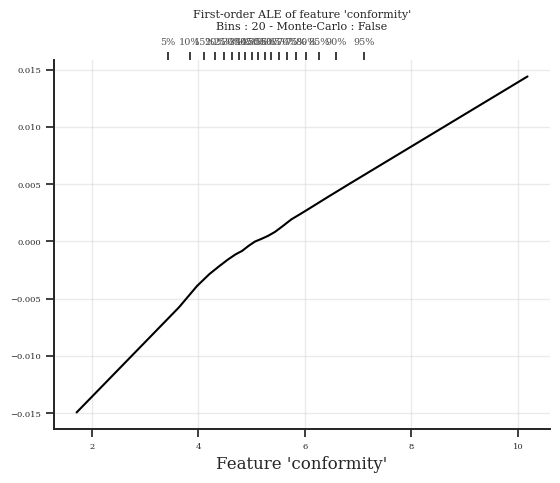

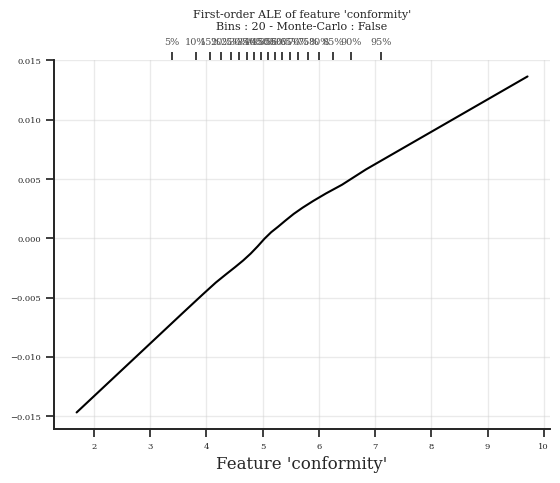

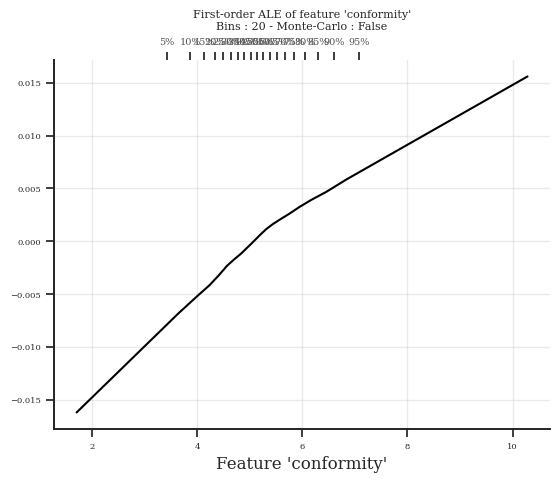

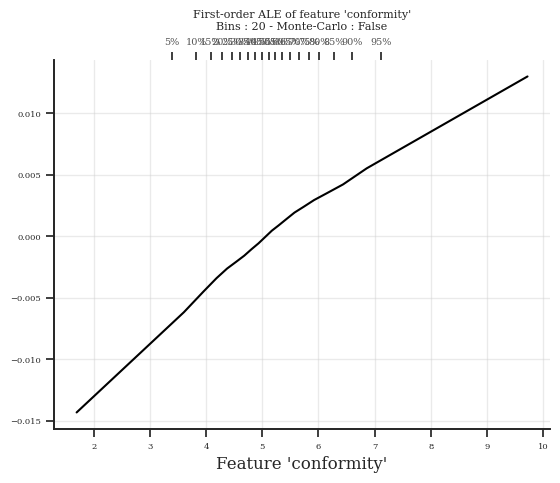

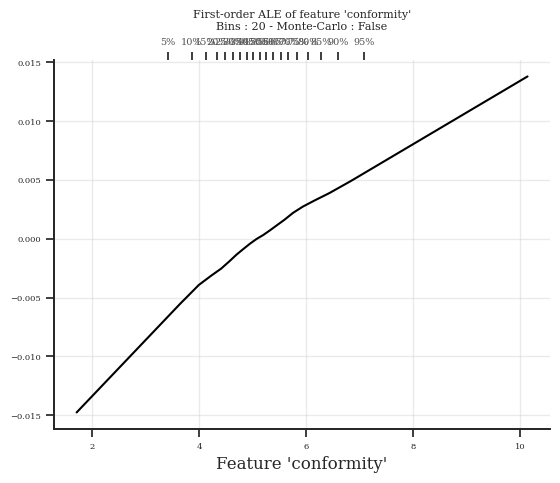

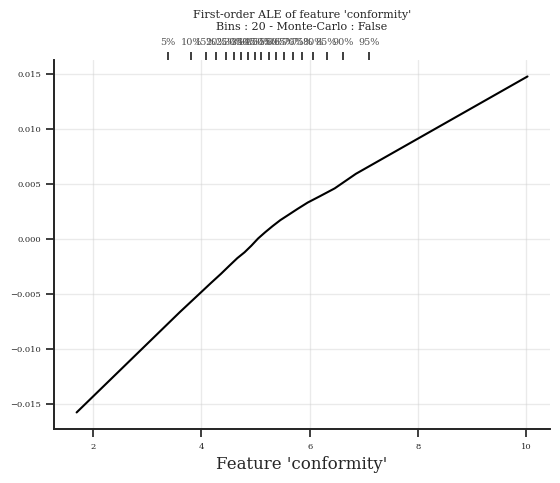

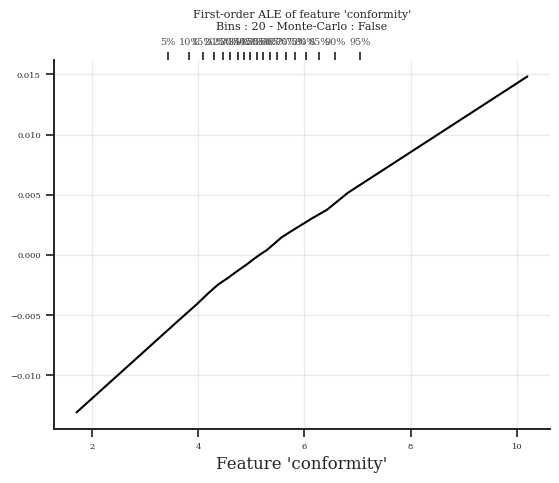

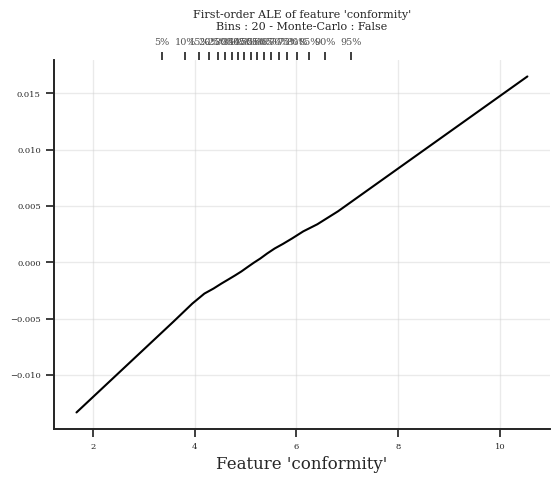

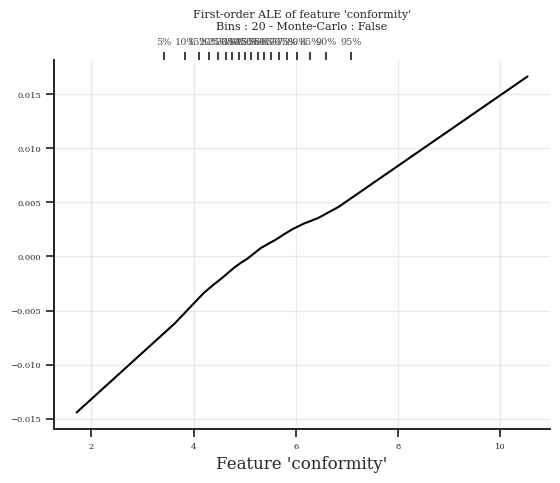

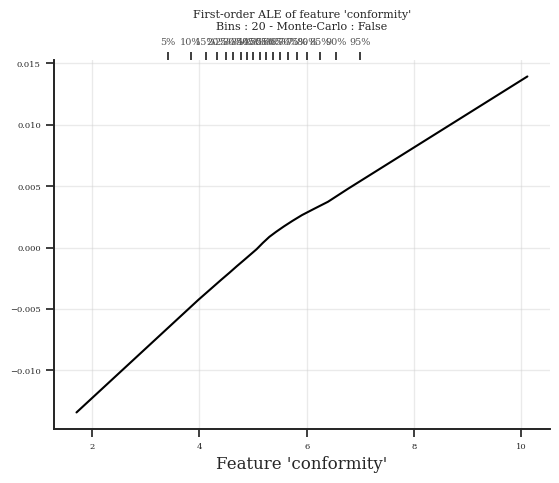

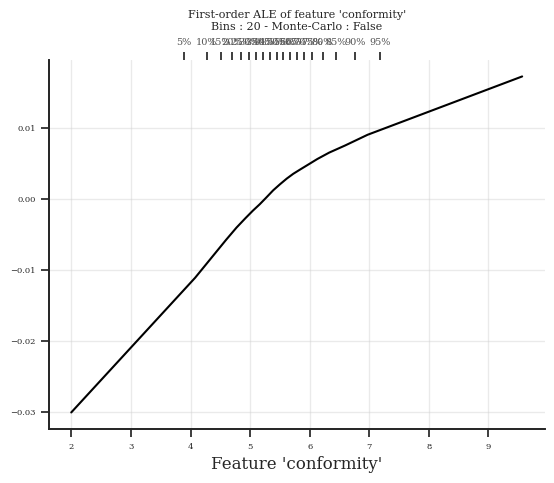

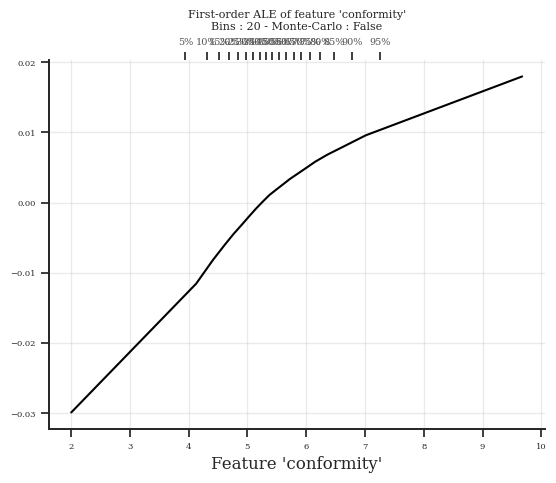

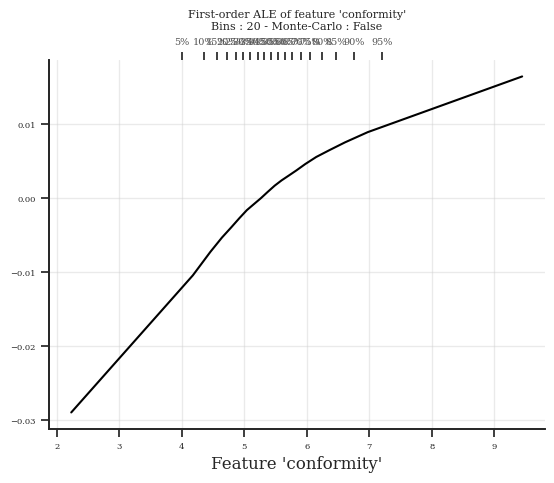

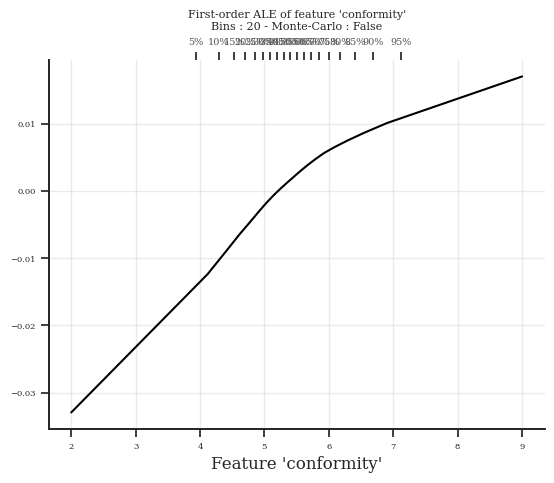

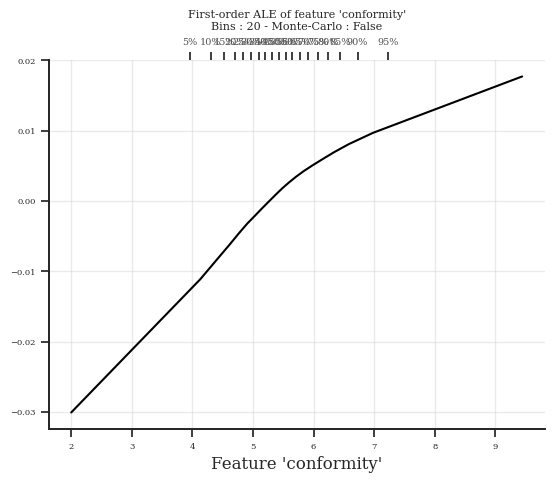

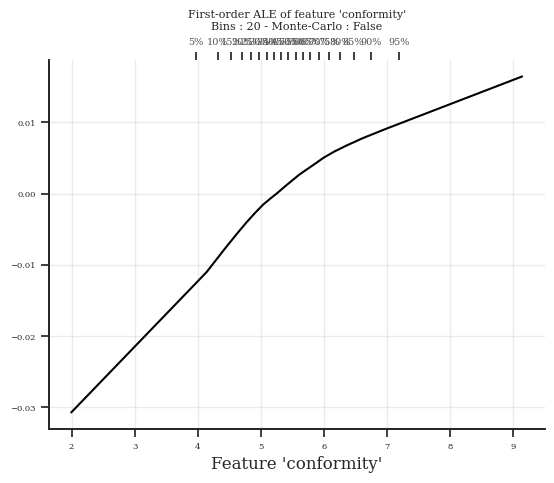

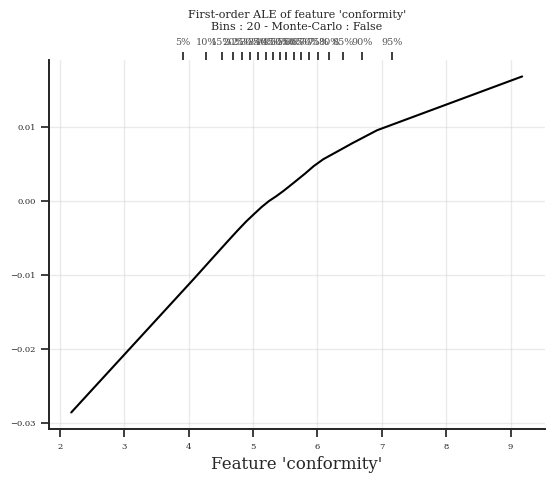

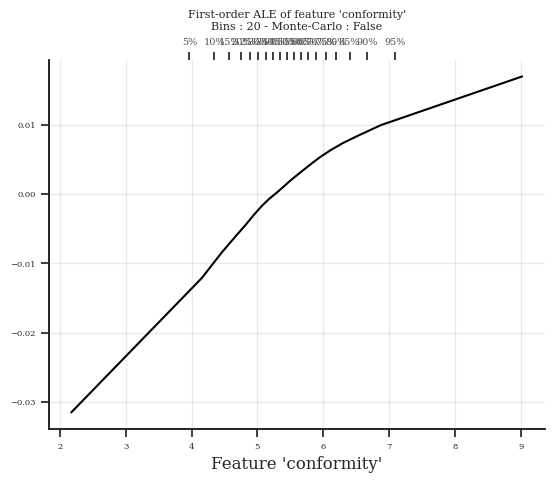

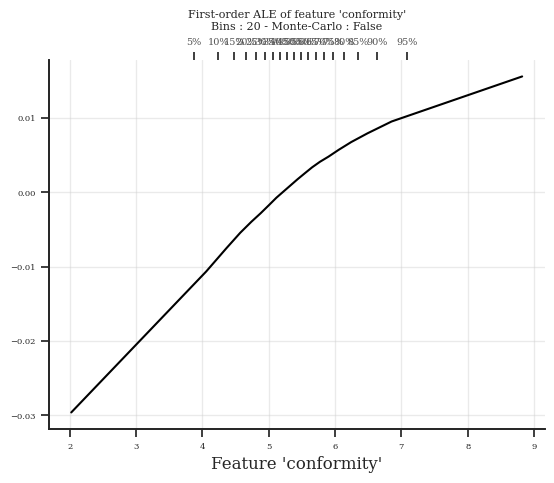

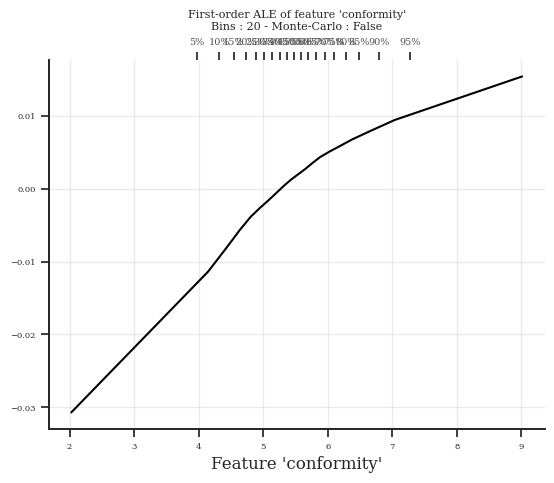

In [12]:
ALE_1ST_19 = {'RNN_Model': []}
ALE_1ST_23 = {'RNN_Model': []}
n_bootstrap = 10

for dataset, year in zip([dataset19, dataset23], ['19', '23']):
    for _ in range(n_bootstrap):
        sub_dataset = dataset_sampling(dataset, 1000)
        _, ale_1st, _ = compute_ale(sub_dataset, 'rmsn_' + str(exp_name), b_use_predicted_confounders=False, features=['conformity'], default_quantiles=quantiles)
        eval(f'ALE_1ST_{year}')['RNN_Model'].append(ale_1st)


ALE_1ST_19['RNN_Model'] = np.array(ALE_1ST_19['RNN_Model'])
ALE_1ST_23['RNN_Model'] = np.array(ALE_1ST_23['RNN_Model'])
ale_dataset_19 = create_ale_dataset(ALE_1ST_19, quantiles, dataset19['treatments'], ['RNN_Model'], 'conformity')
ale_dataset_23 = create_ale_dataset(ALE_1ST_23, quantiles, dataset23['treatments'], ['RNN_Model'], 'conformity')

In [13]:
# 获取个体数据集
n_bootstrap = 1000
ICE = {
    'ICE_19': [],
    'ICE_23': []
}
for dataset, ice_name in zip([dataset19, dataset23], ['ICE_19','ICE_23']):
    # 初始化新数据集
    indiv_dataset = {
        'covariates': np.zeros((n_bootstrap * 3, 161, 23), dtype='float32'),
        'outcomes': np.zeros((n_bootstrap * 3, 161, 1), dtype='float32'),
        'sequence_length': np.zeros((n_bootstrap * 3,), dtype='int64'),
        'treatments': np.zeros((n_bootstrap * 3, 161, 1), dtype='float32')
    }
    for index in range(n_bootstrap):
        indiv_data = select_indiviudal_from_dataset(dataset, index)
        start_idx = index * 3
        end_idx = start_idx + 3

        indiv_dataset['covariates'][start_idx:end_idx] = indiv_data['covariates']
        indiv_dataset['outcomes'][start_idx:end_idx] = indiv_data['outcomes']
        indiv_dataset['sequence_length'][start_idx:end_idx] = indiv_data['sequence_length']
        indiv_dataset['treatments'][start_idx:end_idx] = indiv_data['treatments']
        
    indiv_dataframe, predictor = construct_relevant_dataframe(indiv_dataset,'rmsn_' + str(exp_name), b_use_predicted_confounders=False)

    ice = compute_ice(predictor, 
                      indiv_dataframe, 
                      ['conformity'], 
                      20, 
                      quantiles)
    ICE[ice_name] = ice

results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 25.20it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 23.93it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 23.76it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 22.71it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 25.50it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 22.91it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 23.65it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 23.40it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 23.26it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 23.11it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 24.11it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 23.02it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 25.53it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 25.09it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 26.39it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 22.67it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 21.86it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 23.90it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 22.60it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 23.26it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 21.60it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 21.94it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 24.37it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 24.29it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 18.36it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 23.85it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 24.36it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 24.34it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 23.05it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 23.96it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 25.27it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 25.18it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 25.40it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 24.03it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 22.25it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 22.91it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 21.37it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 24.71it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 23.82it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:01, 24.00it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 23.04it/s]


results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted.csv


INFO:Successfully loaded model from results/rmsn_base_model_optimal_v2_use_confounders_False/rnn_propensity_weighted/rnn_propensity_weighted_0.1_72_200_64_0.01_0.5_60_optimal
Predicting rnn_propensity_weighted: 47it [00:02, 23.09it/s]


In [17]:
ice_dataset_19 = create_ice_dataset({'RNN_Model':ICE['ICE_19']}, quantiles, ['RNN_Model'], 'conformity')
# first_values = ice_dataset_19['conformity__RNN_Model__ice'].values[:,0]
# X_sampled = np.expand_dims(first_values, axis=1)  # 将一维数组转换为二维数组，以匹配 X_sampled 的格式
# # 假设 ice_dataset_19 中有一个维度 'n_bootstrap'
# ice_dataset_19 = ice_dataset_19.assign(X_sampled=(['n_bootstrap', 'feature'], X_sampled))
# ice_dataset_19 = ice_dataset_19.assign(features=(['feature'], ['first_values']))

ice_dataset_23 = create_ice_dataset({'RNN_Model':ICE['ICE_23']}, quantiles, ['RNN_Model'], 'conformity')

In [52]:
ice_19_first_5_rows = ice_dataset_19['conformity__RNN_Model__ice'].values[:5, :]

# 提取 ice_dataset_23 的现有数据
ice_23_data = ice_dataset_23['conformity__RNN_Model__ice'].values

# 将两者在第一个维度上拼接
ice_23_data[:5, :] = ice_19_first_5_rows

# 将拼接后的数据重新赋值给 ice_dataset_23
ice_dataset_23 = ice_dataset_23.assign(
    {"conformity__RNN_Model__ice": (["n_bootstrap", f"n_bins__conformity"], ice_23_data)}
)

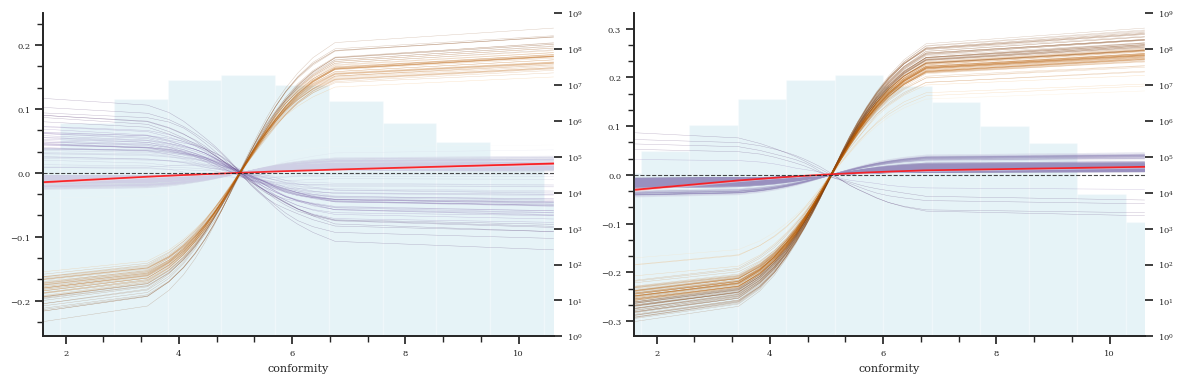

In [53]:
# 创建1×2的图窗
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1行2列的图窗，尺寸为12×6
estimator = [('RNN_Model',RandomForestRegressor())]
explainer = skexplain.ExplainToolkit(estimator)

# 绘制 RNN_Model_19 的 ALE 和 ICE 曲线

explainer.plot_ale(
    ale=ale_dataset_19,
    features='conformity',
    display_units=plotting_config.display_units,
    display_feature_names=plotting_config.display_feature_names,
    ice_curves=ice_dataset_19,
    color_by='first_values',
    ice_alpha=0.3,
    wspace=0.25,
    ax=axs[0]  # 绘制在第一个子图中
)
# axs[0].set_title('RNN_Model_19')  # 设置标题

# 绘制 RNN_Model_23 的 ALE 和 ICE 曲线
explainer.plot_ale(
    ale=ale_dataset_23,
    features='conformity',
    display_units=plotting_config.display_units,
    display_feature_names=plotting_config.display_feature_names,
    ice_curves=ice_dataset_23,
    color_by='first_values',
    ice_alpha=0.3,
    wspace=0.25,
    ax=axs[1]  # 绘制在第二个子图中
)
# axs[1].set_title('RNN_Model_23')  # 设置标题

# 调整图窗布局
plt.tight_layout()

# 显示图窗
plt.show()

# test